In [1]:
#Import the required modules for vectors and matrix operations, data generation
import numpy as np
#Import the required modules for plot creation:
import matplotlib.pyplot as plt
#import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt
#Import formula specification
import statsmodels.formula.api as smf
# Import pandas dataset
import pandas as pd

We will also need some custom functions to make ploting easier:

In [2]:
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

In [3]:
def tsdiag(y, figsize = (14,8), title = "", lags = 10):
    #The data:
    tmp_data = pd.Series(y)
    #The Ljung-Box test results for the first k lags:
    tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # get the p-values
    p_vals = pd.Series(tmp_acor[1])
    #Start the index from 1 instead of 0 (because Ljung-Box test is for lag values from 1 to k)
    p_vals.index += 1
    fig = plt.figure(figsize = figsize)
    #Plot the p-values:
    p_vals.plot(ax = fig.add_subplot(313), linestyle='', marker='o', title = "p-values for Ljung-Box statistic", legend = False)
    #Add the horizontal 0.05 critical value line
    plt.axhline(y = 0.05, color = 'blue', linestyle='--')
    # Annotate the p-value points above and to the left of the vertex
    x = np.arange(p_vals.size) + 1
    for X, Y, Z in zip(x, p_vals, p_vals):
        plt.annotate(round(Z, 4), xy=(X,Y), xytext=(-5, 5), ha = 'left', textcoords='offset points')
    plt.show()
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

Note that these functions are not necessary, but they make plotting much easier since we are always passing a pandas `Series` variable and we will frequently need to plot the data, its autocorrelation, as well as test whether the autocorrelation is significant.

# Time series with trend and seasonality components

We will show an example with `airpass` and `shampoo` datasets.

## Exploratory Data Analysis

We will begin by reading in the data:

In [4]:
airpass = sm.datasets.get_rdataset("AirPassengers", "datasets")

We can examine the `R` documentation of this dataset with

In [5]:
print(airpass.__doc__)

+---------------+-----------------+
| AirPassengers | R Documentation |
+---------------+-----------------+

Monthly Airline Passenger Numbers 1949-1960
-------------------------------------------

Description
~~~~~~~~~~~

The classic Box & Jenkins airline data. Monthly totals of international
airline passengers, 1949 to 1960.

Usage
~~~~~

::

   AirPassengers

Format
~~~~~~

A monthly time series, in thousands.

Source
~~~~~~

Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) *Time Series
Analysis, Forecasting and Control.* Third Edition. Holden-Day. Series G.

Examples
~~~~~~~~

::

   ## Not run: 
   ## These are quite slow and so not run by example(AirPassengers)

   ## The classic 'airline model', by full ML
   (fit <- arima(log10(AirPassengers), c(0, 1, 1),
                 seasonal = list(order = c(0, 1, 1), period = 12)))
   update(fit, method = "CSS")
   update(fit, x = window(log10(AirPassengers), start = 1954))
   pred <- predict(fit, n.ahead = 24)
   tl <- pred$pred 

Finally, we need to get the dataitself and transform it into a time series

In [6]:
airpass = pd.Series(airpass.data["value"])
airpass.index = pd.date_range(start = "1949-01", periods = len(airpass.index), freq = "M").to_period()
airpass.index = airpass.index.to_timestamp()
airpass.head()

1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: value, dtype: int64

----

### (1.1) Data Plot

We begin by plotting our data as follows

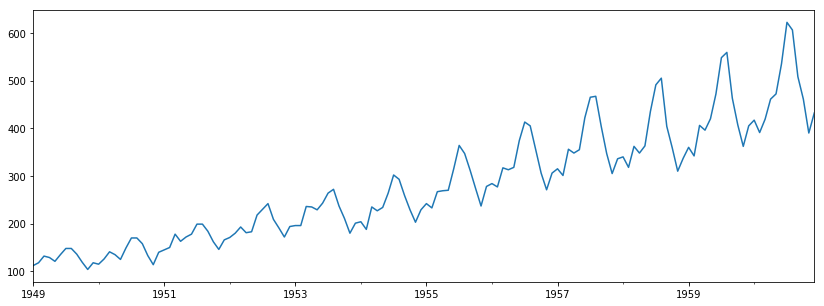

In [7]:
fig = plt.figure(figsize = (14, 5))
airpass.plot(ax = fig.add_subplot(111))
plt.show()

We note a couple of visuall indications of non-stationarity:
    
    - The mean of the process appears to be increasing as time increases;
    - The variance of the process (i.e. the fluctuations) appear to be smaller at the beginning and much larger at the end of the time series
    - The monthly data appears to exhibit a seasonality pattern

We can view this seasonality by plotting each year as a separate plot.

Note that since we have a time series variable

In [8]:
airpass.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

We can extract its `year` and `month`

In [9]:
print(airpass.index.year)
print(airpass.index.month)

Int64Index([1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
            ...
            1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960],
           dtype='int64', length=144)
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
             3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
           dtype='int64', length=144)


which we can use to transpose the data:

In [10]:
data_to_plot = pd.pivot_table(airpass.to_frame(), index = airpass.index.month, columns = airpass.index.year)
data_to_plot.head()

value                                                       
   1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
1   112  115  145  171  196  204  242  284  315  340  360  417
2   118  126  150  180  196  188  233  277  301  318  342  391
3   132  141  178  193  236  235  267  317  356  362  406  419
4   129  135  163  181  235  227  269  313  348  348  396  461
5   121  125  172  183  229  234  270  318  355  363  420  472

and plot the seasonal plots

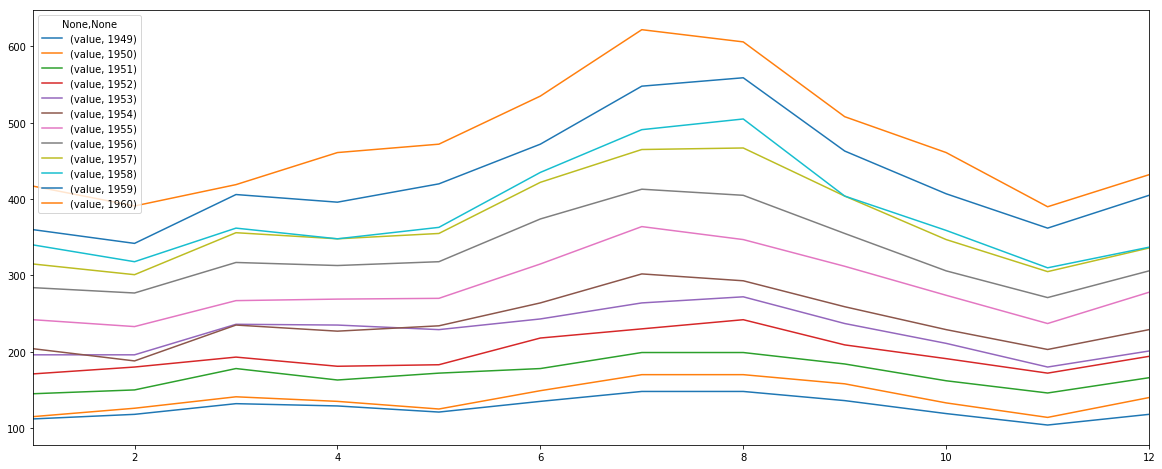

In [11]:
fig = plt.figure(figsize = (20, 8))
data_to_plot.plot(ax = fig.add_subplot(111))
plt.show()

We see that there appears to be an increase in passengers between June and August yeach year, with the least amount of airline passengers in February and November of each year.

This appears to be a deterministic (i.e. non-random and repeating) pattern.

Overall, we have that the series is not stationary.

---

### (1.2) Autocorrelation

One way to check for autocorrelation is to examine the ACF and PACF plots, which we can do using our own `tsdisplay` function:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


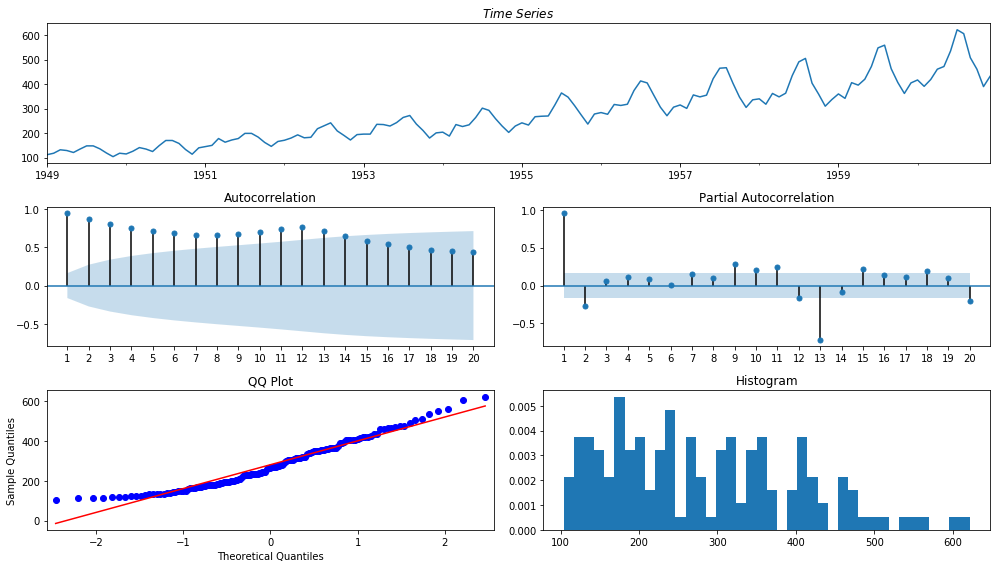

In [12]:
tsdisplay(airpass)

To test for significant autocorrelation with  the `Ljung-Box` test. We will again opt to use our won function as it is a bit more convenient:

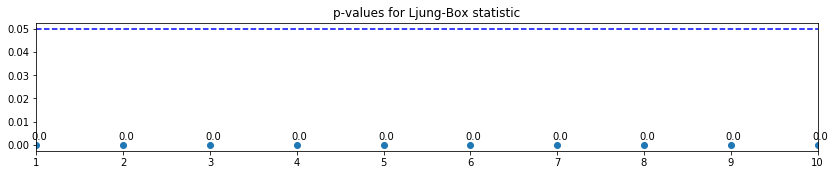

1             2             3             4   \
Ljung-Box: X-squared   1.321415e+02  2.456462e+02  3.426748e+02  4.277387e+02   
Ljung-Box: p-value     1.393231e-30  4.556318e-54  5.751088e-74  2.817731e-91   
Box-Pierce: X-squared  1.294263e+02  2.398212e+02  3.335270e+02  4.150951e+02   
Box-Pierce: p-value    5.471060e-30  8.384679e-53  5.499710e-72  1.522155e-88   

                                  5              6              7   \
Ljung-Box: X-squared    5.047966e+02   5.756019e+02   6.430386e+02   
Ljung-Box: p-value     7.360195e-107  4.264008e-121  1.305463e-134   
Box-Pierce: X-squared   4.884584e+02   5.553839e+02   6.186636e+02   
Box-Pierce: p-value    2.473624e-103  9.752966e-117  2.327567e-129   

                                  8              9              10  
Ljung-Box: X-squared    7.094845e+02   7.795912e+02   8.570686e+02  
Ljung-Box: p-value     6.496271e-148  5.249370e-162  1.100789e-177  
Box-Pierce: X-squared   6.805584e+02   7.453831e+02   8.164925e+02  
Box-Pierce: p-value    1.095987e-141  1.203020e-154  5.870025e-169

In [13]:
tsdiag(airpass)

Since all the `p-value`s are less than the 0.05 critical value, we reject the null hypothesis of no autocorrelation and conclude that the series is autocorrelated.

We also see from the ACF plot that:

- the ACF decayse very slowly - this indicates a trend effect.
- the ACF plot exhibits a larger correlation at around every $12^{th}$ lag (at lags 12, 24, 36, etc. the correlation spykes). This is an indication that there is a seasonal (or cyclic) component in our data.

Since we have monthly data, where every $12^{th}$ lag exhibits a stronger autocorrelation, the seasonal period is $d = 12$. Usually the seasonal period equal the frequency of the time series.

---

### (1.3) Decomposition Type and data transformation

We again state that the variance of the process (i.e. the fluctuations) appear to be smaller at the beginning and much larger at the end of the time series. This indicated that our series may be **multiplicative**: $Y_t = T_t \cdot S_t \cdot E_t$.

Since in practice it is much easier to deal with **additive series**: $Y_t = T_t + S_t + E_t$, we will transform the data by taking the logarithms:

In [14]:
log_passengers = np.log(airpass)

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


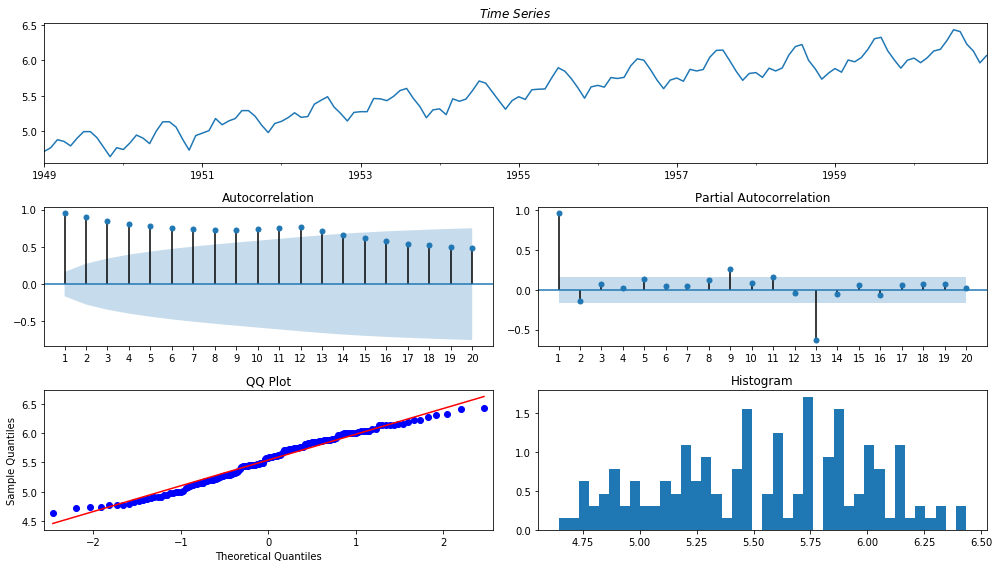

In [15]:
tsdisplay(log_passengers)

The series appears to now have a constant variance - the fluctuations at the beginning appear to be similar to those at the end of the time series.

Note that the minimum value in our series is a positive value:

In [16]:
print(airpass.min())

104


hence we can take the logarithms of our data.

---

## (2.1) Time Series Decomposition WITHOUT Forecasts

We will begin by examining a simple decomposition method based on averaging (more specifically we select the amount of values that we will use for the averaging and "move" the averaging window based on time $t$). This is known as the **moving-average** method for decomposition.

We will begin by estimating the trend component of the series.

### Trend Decomposition via Moving Average

We will provide an example of the moving-average method for decomposition.

If we select the length of the moving average as an *odd* number, for example $l = 3$, then:

- The two-sided moving-average:

$$\widehat{T}_t = \dfrac{Y_{t-1} + Y_t + Y_{t+1}}{3}$$

- The one-sided moving-average:

$$\widehat{T}_t = \dfrac{Y_{t-2} + Y_{t-1} + Y_t}{3}$$

are calculated for **integer** times $t$.

If the time series contains a seasonal component and we want to averate it out, the length of the moving average **must be equal to the seasonal** frequency (for a monthly series, the length $l = 12$). **However**, there is a slight hurdle - suppose, our times series begin in January ($t = 1$) and we average up to December ($t = 12$). This average corresponds to a time $t = 6.5$ - a time between June and July.

When we come to estimate seasonal effects, we need a moving-average at *integer* times. This can be achieved by averaging the average of January to December and the average of February ($t = 2$) to January ($t = 13$). This average of the two moving averages corresponds to $t = 7$ and the process is called **centering**.

Thus, the trend at time $t$ can be estimated by the centered moving average:

- Two-sided averaging:
$$
\begin{aligned}
\widehat{T}_t &= \dfrac{(Y_{t-6} +...+ Y_{t+5})/12 + (Y_{t-5} +...+ Y_{t+6})/12}{2} = \dfrac{(1/2)Y_{t-6} + Y_{t-5}...+ Y_{t+5}+ (1/2)Y_{t+6}}{12}
\end{aligned}
$$

- One-sided averaging:
$$
\begin{aligned}
\widehat{T}_t &= \dfrac{(Y_{t-12} +...+ Y_{t-1})/12 + (Y_{t-11} +...+ Y_{t})/12}{2} = \dfrac{(1/2)Y_{t-12} + Y_{t-11}...+ Y_{t-1}+ (1/2)Y_{t}}{12}
\end{aligned}
$$

Note that the weights are different for the first and last elements used in the averaging. we can use the [statsmodels.tsa.seasonal.seasonal_decompose](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose our series.

We will begin with a *two-sided* decomposition:

In [17]:
decomposition_1  = smt.seasonal.seasonal_decompose(log_passengers, model = "additive", freq = 12, two_sided = True)
trend_1 = decomposition_1.trend

We can plot this decomposition alongside the time series

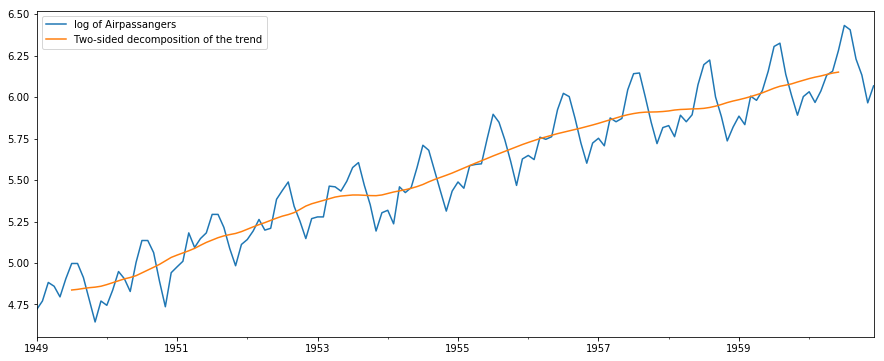

In [18]:
plt.figure(figsize = (15, 6))
log_passengers.plot(label = "log of Airpassangers")
trend_1.plot(label = "Two-sided decomposition of the trend")
plt.legend()
plt.show()

Since we used a two-sided decomposition, we cannot calculate the trend for the first and last 6 months of our monthly time series.

On the other hand, if we specify a one-sided decomposition, then we will not be able to calculate the trend for the first 12 months:

In [19]:
decomposition_2  = smt.seasonal.seasonal_decompose(log_passengers, model = "additive", freq = 12, two_sided = False)
trend_2 = decomposition_2.trend

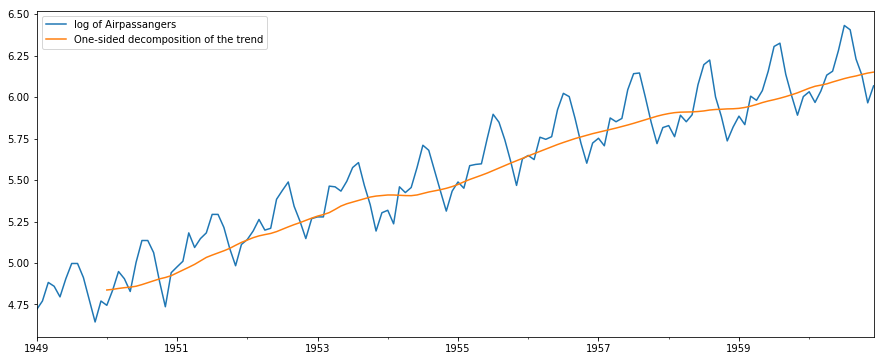

In [20]:
plt.figure(figsize = (15, 6))
log_passengers.plot(label = "log of Airpassangers")
trend_2.plot(label = "One-sided decomposition of the trend")
plt.legend()
plt.show()

---
---

We would like to stress the importance of correctly selecting the period of the series. If we select a lower period value, then we will begin to capture the seasonal part with our **trend filter**. 

For example, selecting the moving average length $l = 3$, or selecting too large of a period frequency length, say $l = 19$, yields:

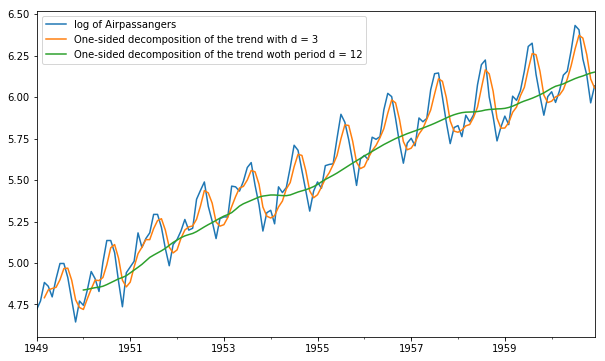

In [21]:
decomposition_3  = smt.seasonal.seasonal_decompose(log_passengers, model = "additive", freq = 3, two_sided = False)
trend_3 = decomposition_3.trend

plt.figure(figsize = (10, 6))
log_passengers.plot(label = "log of Airpassangers")
trend_3.plot(label = "One-sided decomposition of the trend with d = 3")
trend_2.plot(label = "One-sided decomposition of the trend woth period d = 12")
plt.legend()
plt.show()

This can be explained by looking at the formulas for the moving averagedecomposition - this is because we are using fewer observations around time $t$. So, our estimated trend values would be closer to the overall series value. However, in doing so, we are not estimating the trend component correctly. As such, it is important to correctly determine whether your data exhibits a seasonal component and if so - to correctly determine the seasonal frequency.

Furthermore, specifying too large of a period frequency length, say $l = 19$ yields:

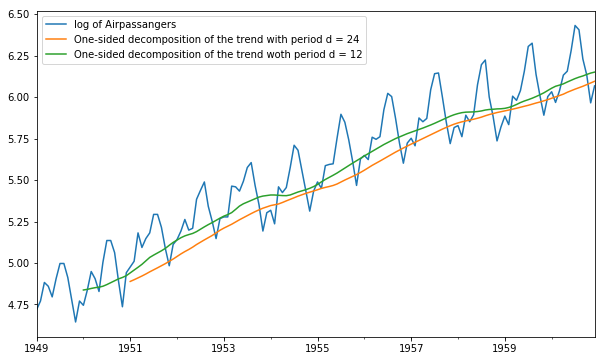

In [22]:
decomposition_4  = smt.seasonal.seasonal_decompose(log_passengers, model = "additive", freq = 24, two_sided = False)
trend_4 = decomposition_4.trend

plt.figure(figsize = (10, 6))
log_passengers.plot(label = "log of Airpassangers")
trend_4.plot(label = "One-sided decomposition of the trend with period d = 24")
trend_2.plot(label = "One-sided decomposition of the trend woth period d = 12")
plt.legend()
plt.show()

Notice that too large of a period may not capture the trend as accurately. Again, as we take more values, which cover more than one period, we calculate the average value over **more than one period**, hence our trend estimate is not as accurate.

---

We could also try to specify our own function to decompose the trend only:

In [23]:
import math as math

def moving_average_decompose(y, l = 12):
    tmp_index = y.index
    #Time Series:
    y = np.array(y)
    #Trend Component:
    t_two_side = pd.np.zeros(y.size)
    t_one_side = pd.np.zeros(y.size)
    tmp_val = 0
    #Loop through each time point:
    for j in range(0, y.size):
        ###########################################################
        # The length is even - use centered averaging:
        if l % 2 == 0:
            # The centered averaging method weights - see the formula example with l = 12.
            tmp_weights = np.concatenate([np.array([1 / (l * 2)]),
                                          np.repeat(1 / l, l - 1),
                                          np.array([1 / (l * 2)])])
            #Two-sided
            if j + 1 <= l / 2 or j + 1 > y.size - l / 2: 
                # We do not have enough data to the left or right of the series to calculate trend at time t = j:
                t_two_side[j] = np.nan
            else:
                tmp_val = y[int(j - (l / 2)):int(j + (l / 2 + 1))] * tmp_weights
                t_two_side[j] = tmp_val.sum()
            #One-sided
            if j + 1 <= l:
                t_one_side[j] = np.nan
            else:
                tmp_val = y[int(j - l):int(j + 1)] * tmp_weights
                t_one_side[j] = tmp_val.sum()
        ###########################################################
        # The length is odd:
        else:
            #For the non-centered averaging the weights are simply the mean, i.e. the length l.
            #tmp_weights = np.repeat(1 / l, l)
            #Two-sided
            if j + 1 <= math.floor(l / 2) or j + 1 > y.size - math.floor(l / 2):
                # We do not have enough data to the left or right of the series to calculate trend at time t = j:
                t_two_side[j] = np.nan
            else:
                tmp_val = y[int(j - math.floor(l / 2)):int(j + (math.floor(l / 2) + 1))]
                t_two_side[j] = tmp_val.mean()
            
            #One-sided
            if j * 2 <= l:
                t_one_side[j] = np.nan
            else:
                tmp_val = y[int(j - l + 1):int(j + 1)]
                t_one_side[j] = tmp_val.mean()
    #Return the same time series:
    t_one_side = pd.Series(t_one_side, name = "One-Sided MA with length = " + str(l))
    t_one_side.index = tmp_index
    t_two_side = pd.Series(t_two_side, name = "Two-Sided MA with length = " + str(l))
    t_two_side.index = tmp_index
    
    return {"Two-sided": t_two_side, "One-sided": t_one_side}

Here we have applied the formulas for calculating the moving average for both odd and even length of the period.

We can test our function as follows:

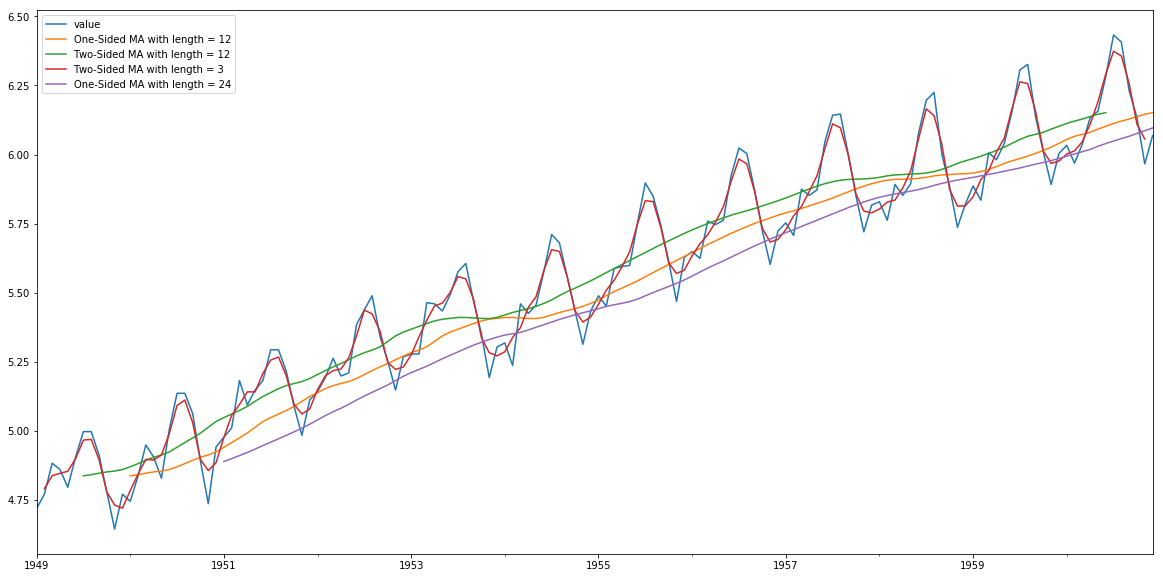

In [24]:
decomposition_custom_1 = moving_average_decompose(log_passengers)
decomposition_custom_2 = moving_average_decompose(log_passengers, l = 3)
decomposition_custom_3 = moving_average_decompose(log_passengers, l = 24)

plt.figure(figsize = (20, 10))
log_passengers.plot()
decomposition_custom_1["One-sided"].plot()
decomposition_custom_1["Two-sided"].plot()
decomposition_custom_2["Two-sided"].plot()
decomposition_custom_3["One-sided"].plot()
plt.legend()
plt.show()

Furthermore, we may wish to compare it with the built-in function:

In [25]:
comparison = decomposition_custom_1["Two-sided"] - trend_1
print("Two-Sided MA, l = 12: max. difference = ", round(comparison.max(), 5), "; min. difference = ", round(comparison.min(), 5))
comparison = decomposition_custom_1["One-sided"] - trend_2
print("One-Sided MA, l = 12: max. difference = ", round(comparison.max(), 5), "; min. difference = ", round(comparison.min(), 5))
comparison = decomposition_custom_2["One-sided"] - trend_3
print("One-Sided MA, l =  3: max. difference = ", round(comparison.max(), 5), "; min. difference = ", round(comparison.min(), 5))
comparison = decomposition_custom_3["One-sided"] - trend_4
print("One-Sided MA, l =  24: max. difference = ", round(comparison.max(), 5), "; min. difference = ", round(comparison.min(), 5))

Two-Sided MA, l = 12: max. difference =  0.0 ; min. difference =  -0.0
One-Sided MA, l = 12: max. difference =  0.0 ; min. difference =  -0.0
One-Sided MA, l =  3: max. difference =  0.0 ; min. difference =  -0.0
One-Sided MA, l =  24: max. difference =  0.0 ; min. difference =  -0.0


Note the smallest and largest value are approximately zero. This means that our calculations are approximately the same as the ones provided by `statsmodels`.

---
---

Having estimated the trend, we can move on to estimating the seasonal effect.

### Seasonal Effect Decomposition

We will decompose the seasonal effect using both trend averaging methods and examine how the decomposition fits the data. We will employ the following algorithm:

 1. Estimate the trend component $T_t$ using the moving average method;
 1. Estimate the seasonal component as $\widehat{S}_t = Y_t - \widehat{T_t}$, $t = 1,...,T$;
 2. Decide on the seasonal period $d$ such that: $S_t = S_{t+d}$ and $\sum_{t = 1}^d S_t = 0$. Then, calculate $\overline{S}_k = \dfrac{1}{N} \sum_{j = 1}^N \widehat{S}_{j\cdot k}$, $k = 1,...,d$, where $N = \lfloor T / d \rfloor$;
 3. Calculate the total sum: $S_{tot} = \sum_{k = 1}^d \overline{S}_k$;
 4. Calculate $w = \dfrac{1}{d} \sum_{k = 1}^d S_{tot}$;
 5. Adjust each seasonal factor: $\widetilde{S}_t = \widehat{S}_t - w$;
 6. We now have estimated the seasonal component $\widetilde{S}_t$ such that $\widetilde{S}_t = \widetilde{S}_{t+d}$ and $\sum_{t= 1}^d \widetilde{S}_t = 0$.


---
---

Since we have already calculated the trend, we can implement the rest of the procedure (under the assumption that the time series starts from the first season, i.e. January for monthly data) as follows:

In [26]:
def decomp_seas(y, trend, period = 12, title = ""):
    #Initial seasonal component estimation:
    seas_0 = y - trend
    seas_1 = pd.np.zeros(period)
    #Seasonal component averaging:
    for j in range(0, period):
        #Select every j-th month from each year in the dataset:
        seas_1[j] = seas_0[j::period].mean()
    #Adjustment factor:
    w = seas_1.mean()
    seas_1 = seas_1 - w
    #Save the seasonal component in a time series format:
    seasonal_results = pd.np.zeros(y.size)
    for j in range(0, period):
        #Select every j-th month from each year in the dataset:
        seasonal_results[j::period] = seas_1[j]
    
    seasonal_results = pd.Series(seasonal_results, name = "Seasonal " + title)
    seasonal_results.index = trend.index
    return(seasonal_results)

We can now test it and estimate the seasonal component for both one-sided and two-sided trend decomposition:

In [27]:
seas_results = {"One-sided": decomp_seas(y = log_passengers, trend = decomposition_custom_1["One-sided"], period = 12, title = "(One-sided)"),
                "Two-sided": decomp_seas(y = log_passengers, trend = decomposition_custom_1["Two-sided"], period = 12, title = "(Two-sided)")}

We can compare how the seasonal components differ for one-sided and two-sided methods:

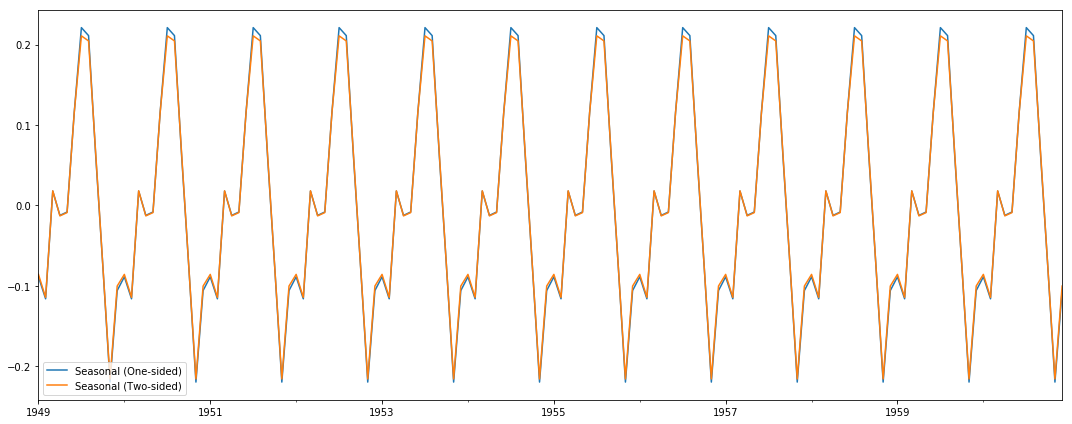

In [28]:
plt.figure(figsize = (15, 6))
seas_results["One-sided"].plot()
seas_results["Two-sided"].plot()
plt.legend()
plt.tight_layout()
plt.show()

Note that by construction of the algorithm $\widetilde{S}_t = \widetilde{S}_{t+d}$, meaning we have the seasonal component decomposed for the **whole** series, unlike the one-sided and two-sided decomposition of the trend component.

Furthermore, we can add the seasonality component to the trend component to get the overall deterministic component $\widehat{T}_t + \widetilde{S}_t$:

In [29]:
T_S = {"One-sided": decomposition_custom_1["One-sided"] + seas_results["One-sided"], "Two-sided": decomposition_custom_1["Two-sided"] + seas_results["Two-sided"]}
T_S["One-sided"].name = "Trend + Season"
T_S["Two-sided"].name = "Trend + Season"

Finally, we want to see how all of these component look alongside one another and the whole time series:

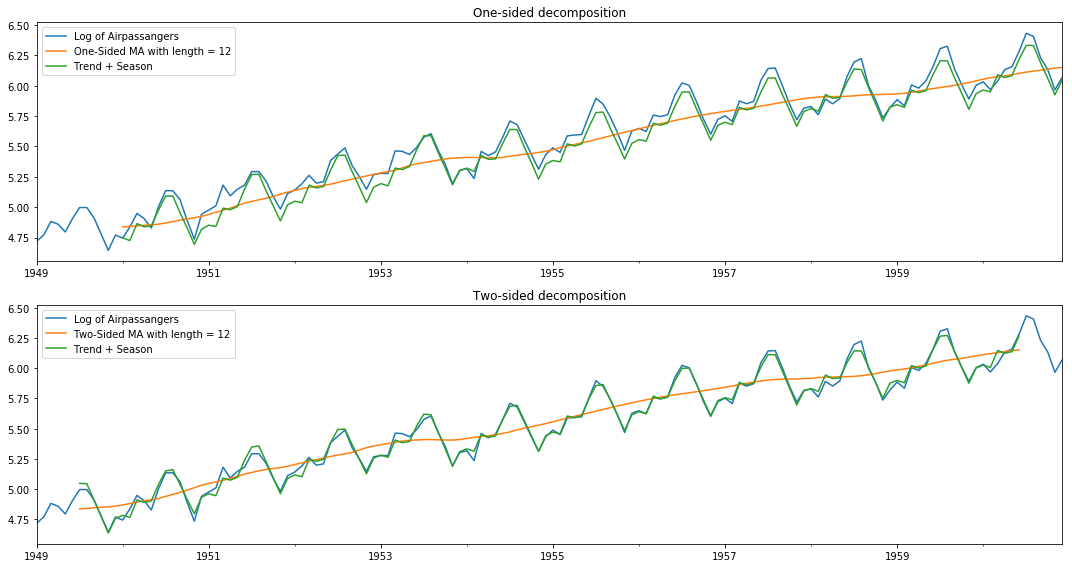

In [30]:
fig = plt.figure(figsize = (15, 8))
log_passengers.plot(ax = fig.add_subplot(211), label = "Log of Airpassangers", title = "One-sided decomposition")
decomposition_custom_1["One-sided"].plot()
T_S["One-sided"].plot()
plt.legend()
#
log_passengers.plot(ax = fig.add_subplot(212), label = "Log of Airpassangers", title = "Two-sided decomposition")
decomposition_custom_1["Two-sided"].plot()
T_S["Two-sided"].plot()
plt.legend()
#
plt.tight_layout()
plt.show()

The decomposed trend and seasonality fit the data much nicer compared to only the trend component. Furthermore, the two-sided decomposition method appears to fit the data much closer than the one-side method. The downside is that we do not have the `trend` and consequently the `trend + seasonality` for the last 6 months of the series.



We can do the same etimation using the results from `smt.seasonal.seasonal_decompose`, which we have already calculated before. First, we note that the estimated seasonal component does not differ from the one we estimated manually:

In [31]:
comparison = seas_results["Two-sided"] - decomposition_1.seasonal
print("Two-Sided MA, l = 12: max. difference = ", round(comparison.max(), 5), "; min. difference = ", round(comparison.min(), 5))
comparison = seas_results["One-sided"] - decomposition_2.seasonal
print("One-Sided MA, l = 12: max. difference = ", round(comparison.max(), 5), "; min. difference = ", round(comparison.min(), 5))

Two-Sided MA, l = 12: max. difference =  0.0 ; min. difference =  -0.0
One-Sided MA, l = 12: max. difference =  0.0 ; min. difference =  -0.0


So, the manual estimation method is identical to the built-in method provided in `statsmodels`

---
---

We can also print the output from `smt.seasonal.seasonal_decompose`:

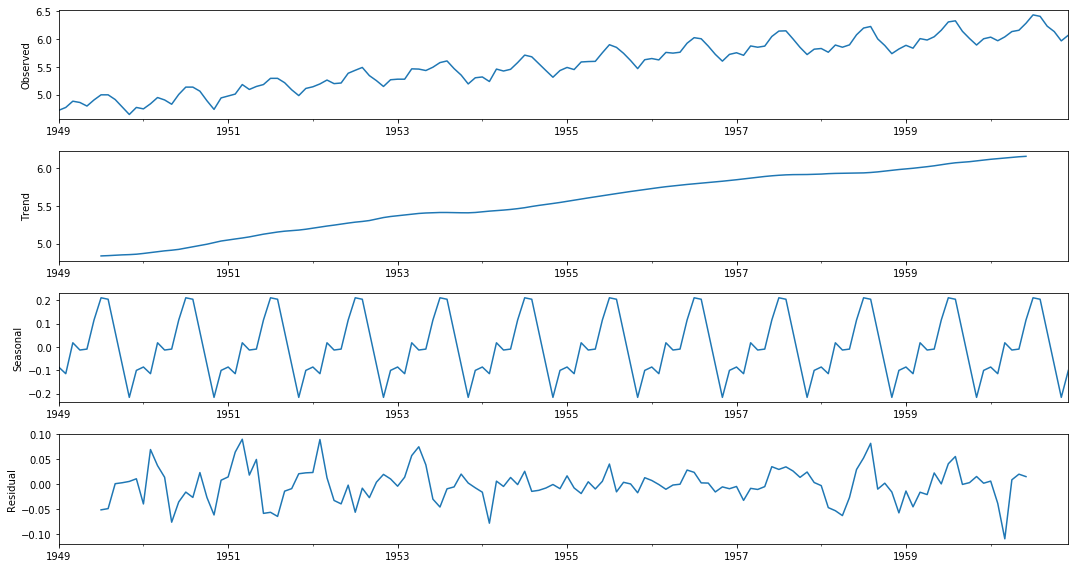

In [32]:
fig, ax = plt.subplots(4, 1, figsize=(15, 8))
# Plot the series
decomposition_1.observed.plot(ax = ax[0])
decomposition_1.trend.plot(ax = ax[1])
decomposition_1.seasonal.plot(ax = ax[2])
decomposition_1.resid.plot(ax = ax[3])
# Add the labels to the Y-axis
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')
# Fix layout
plt.tight_layout()
plt.show()

Or, if we want to plot the same-style plot as before:

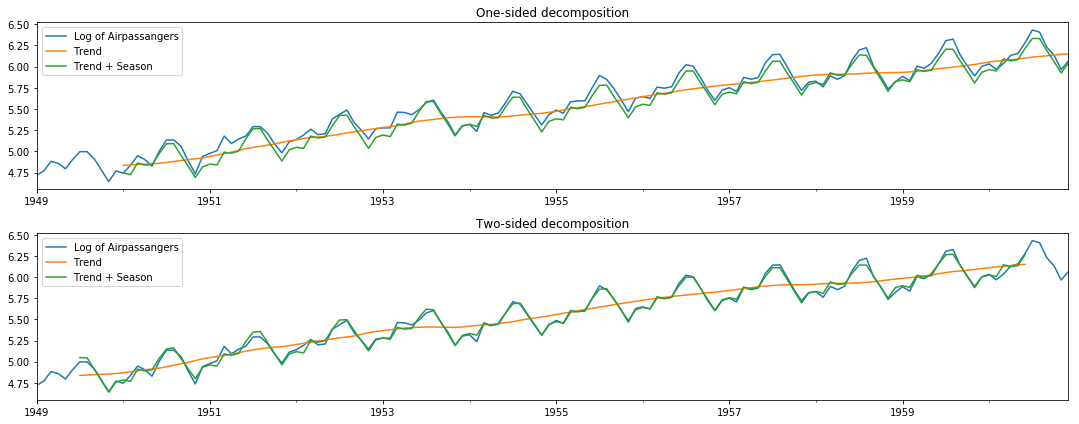

In [33]:
fig = plt.figure(figsize = (15, 6))
#
log_passengers.plot(ax = fig.add_subplot(211), label = "Log of Airpassangers", title = "One-sided decomposition")
decomposition_2.trend.plot(label = "Trend")
(decomposition_2.seasonal + decomposition_2.trend).plot(label = "Trend + Season")
plt.legend()
#
log_passengers.plot(ax = fig.add_subplot(212), label = "Log of Airpassangers", title = "Two-sided decomposition")
decomposition_1.trend.plot(label = "Trend")
(decomposition_1.seasonal + decomposition_1.trend).plot(label = "Trend + Season")
plt.legend()
#
plt.tight_layout()
plt.show()

As mentioned before, this is exatly the same method that we have used to manually specify the calculation.

Finally, we can check if the remained is stationary. We can either calculated it manually:

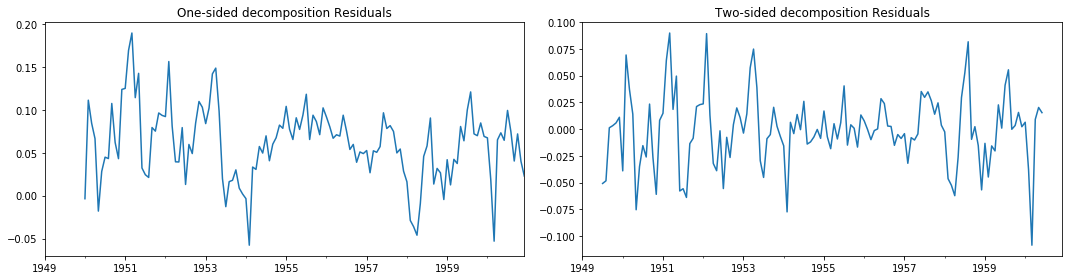

In [34]:
fig = plt.figure(figsize = (15, 4))
(log_passengers - T_S["One-sided"]).plot(ax = fig.add_subplot(121), title = "One-sided decomposition Residuals")
(log_passengers - T_S["Two-sided"]).plot(ax = fig.add_subplot(122), title = "Two-sided decomposition Residuals")
plt.tight_layout()
plt.show()

Or exctract it from the`smt.seasonal.seasonal_decompose` output:

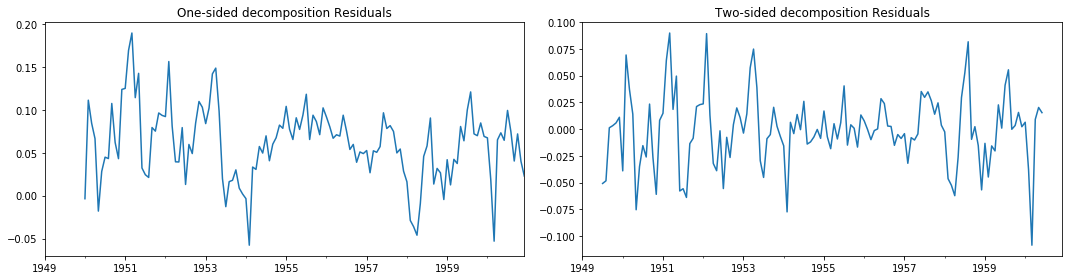

In [35]:
fig = plt.figure(figsize = (15, 4))
decomposition_2.resid.plot(ax = fig.add_subplot(121), title = "One-sided decomposition Residuals")
decomposition_1.resid.plot(ax = fig.add_subplot(122), title = "Two-sided decomposition Residuals")
plt.tight_layout()
plt.show()

We note that the residuals might not be stationary - we can compare the variances from different time periods:

In [36]:
print("Two-sided decomp. Variance for [1949-01-01 - 1954-01-01]: ", round(decomposition_1.resid.loc['19490101':'19540101'].var(), 6))
print("Two-sided decomp. Variance for [1954-02-01 - 1960-12-01]: ", round(decomposition_1.resid.loc['19540201':'19600101'].var(), 6))
print("-----------------------------------------------------------")
print("One-sided decomp. Variance for [1949-01-01 - 1954-01-01]: ", round(decomposition_2.resid.loc['19490101':'19540101'].var(), 6))
print("One-sided decomp. Variance for [1954-02-01 - 1960-12-01]: ", round(decomposition_2.resid.loc['19540201':'19600101'].var(), 6))

Two-sided decomp. Variance for [1949-01-01 - 1954-01-01]:  0.001534
Two-sided decomp. Variance for [1954-02-01 - 1960-12-01]:  0.000709
-----------------------------------------------------------
One-sided decomp. Variance for [1949-01-01 - 1954-01-01]:  0.002611
One-sided decomp. Variance for [1954-02-01 - 1960-12-01]:  0.001283


The residuals in the second-half of the time series appear to have a smaller variance.

Let's also look at the residual correlation plots:

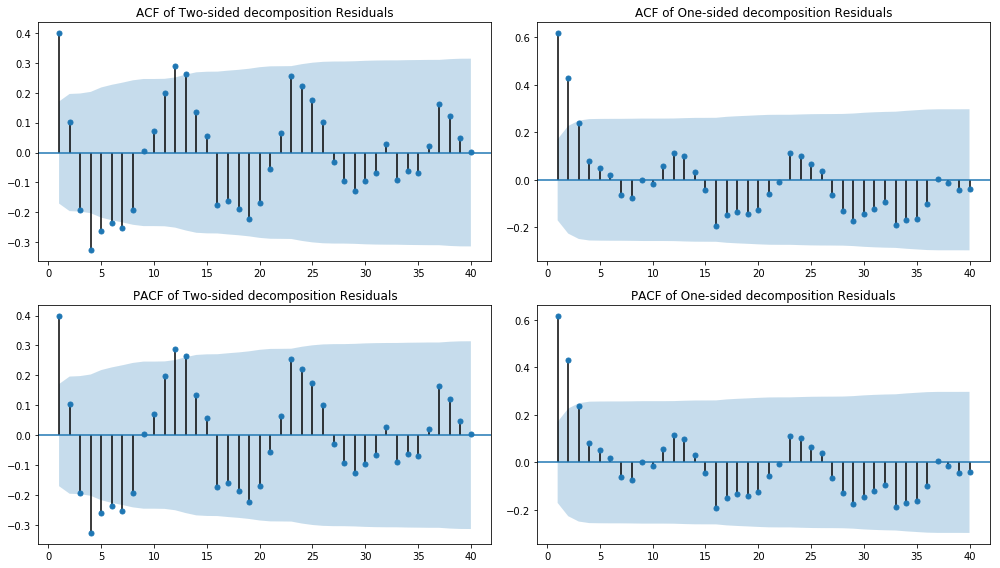

In [37]:
fig = plt.figure(figsize = (14, 8))
fig = sm.graphics.tsa.plot_acf(decomposition_1.resid.dropna(), zero = False, lags=40, ax = fig.add_subplot(221), title = "ACF of Two-sided decomposition Residuals")
fig = sm.graphics.tsa.plot_acf(decomposition_2.resid.dropna(), zero = False, lags=40, ax = fig.add_subplot(222), title = "ACF of One-sided decomposition Residuals")
#
fig = sm.graphics.tsa.plot_acf(decomposition_1.resid.dropna(), zero = False, lags=40, ax = fig.add_subplot(223), title = "PACF of Two-sided decomposition Residuals")
fig = sm.graphics.tsa.plot_acf(decomposition_2.resid.dropna(), zero = False, lags=40, ax = fig.add_subplot(224), title = "PACF of One-sided decomposition Residuals")
#
plt.tight_layout()
plt.show()

The residual series **is not White Noise**, so we would need to try to estimate an $ARMA$ model for it, as long as the residuals are **stationary**. Unfortunately, it seems that the two-sided decomposition still leaves a seasonality effect, as shown by the oscillating residual ACF plot. 

Looking at the residual plots from this decomposition, we note that they do not appear to be stationary for the two-sided decomposition method on this data - the variance is smaller in the middle of the data, compared to the beginning of the time series. It also seems to be the case for the one-sided decomposition residuals as well.

We can see that this decomposition method does not fully eliminate the deterministic components from this specific time series data sample.

Note that this method does **not** allow to produce forecasts.

---

## Time Series Decomposition With Forecasts

We will now examine a number of alternative decomposition methods, which allow to forecast the series, as well as decompose it. These methods usually are more robust and can usually capture the seasonality and trend, which may not be accoutned for via the moving-average decomposition.

### (3.1) The Global Method of OLS

The OLS method estimates coefficients of an additive model. If needed, we can also specify not only a linear but also a polynomial trend. We will estimate three different models via OLS:

- Model 1: $\text{AP}_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \epsilon_t$
- Model 2: $\text{AP}_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \gamma_1 \text{dm}_{1,t} + ... + \gamma_{11} \text{dm}_{11,t} + \epsilon_t$
- Model 3: $\log(\text{AP}_t) = \beta_0 + \beta_1 t + \beta_2 t^2 + \gamma_1 \text{dm}_{1,t} + ... + \gamma_{11} \text{dm}_{11,t} + \epsilon_t$

where:
- $AP_t$ is the monthly airline passenger numbers 1949-1960;
- $t$ is the trend, $\rm t = 1949/01/01, 1950/02/01,..., 1960/12/01$. Equivalently, we can specify $t = 1,..., 144$. The only difference would be the coefficient $\beta_1, \beta_2$ magnitude.
- $\text{dm}_{k,t}$, $k = 1,2,...,11$ - dummy variables indicating the month of time $t$;

Recall, that in order to avoid [the dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html) (a scenario in which the independent variables are multicollinear (highly correlated)) we have to exclude one dummy variable - in this case $\text{dm}_{12,t}$ - from our regression models.

We begin by examining the initial (non-logged) data once more:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


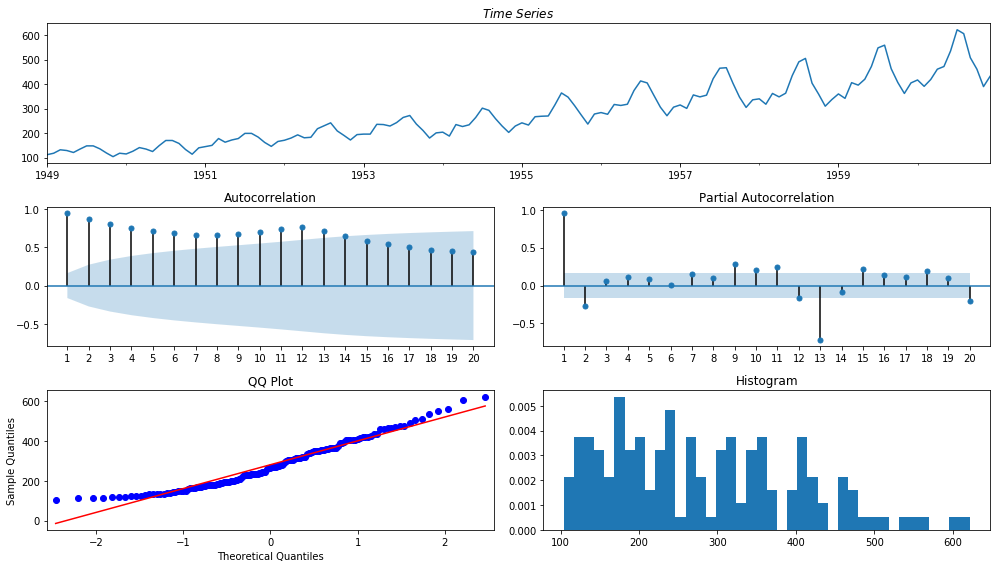

In [38]:
tsdisplay(airpass)

- From the ACFs slow, wavy decay it seems that we have a trend and a seasonal component. 
- From the time series plot is seems that the magnitude of seasonal variance increases as time increases. 

So it seems to be either an exponential or a polynomial growing time series. We need to create additional dummy/indicator variables:

In [39]:
AP = airpass


- the trend component

In [40]:
#Create trend
time = np.array(range(1, len(airpass.index) + 1))
time_sq = time ** 2

- the seasonal indicator variables for January - November

In [41]:
#Create a dummy variable matrix of zeroes:
dm = np.column_stack(np.zeros((11, airpass.size)))
#Create a DataFrame
dm = pd.DataFrame(dm)
#Add values to dummy variables:
for j in range(0, len(dm.columns)):
    #Select every j-th month from each year in the dataset:
    dm.iloc[j::12, j] = 1

In [42]:
dm.head()

0    1    2    3    4    5    6    7    8    9    10
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

Finally, we can combine everything into one data matrix:

In [43]:
dtf = np.column_stack((airpass, time, time_sq, dm))
#Create a DataFrame
dtf = pd.DataFrame(dtf)
#Rename the columns:
dtf.columns = ["AP"] + ["time"] + ["time_sq"] + ["dm_" + str(number) for number in range(1, 12)]
dtf.index = [str(number) for number in range(1, len(dtf.index) + 1)]
dtf.head(13)

AP  time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  \
1   112.0   1.0      1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   118.0   2.0      4.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   132.0   3.0      9.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
4   129.0   4.0     16.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
5   121.0   5.0     25.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
6   135.0   6.0     36.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
7   148.0   7.0     49.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
8   148.0   8.0     64.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
9   136.0   9.0     81.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10  119.0  10.0    100.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11  104.0  11.0    121.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12  118.0  12.0    144.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
13  115.0  13.0    169.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

    dm_9  dm_10  dm_11  
1    0.0    0.0    0.0  
2    0.0    0.0    0.0  
3    0.0    0.0    0.0  
4    0.0    0.0    0.0  
5    0.0    0.0    0.0  
6    0.0    0.0    0.0  
7    0.0    0.0    0.0  
8    0.0    0.0    0.0  
9    1.0    0.0    0.0  
10   0.0    1.0    0.0  
11   0.0    0.0    1.0  
12   0.0    0.0    0.0  
13   0.0    0.0    0.0

To make it a bit easier to specify, we will defined these formulas:

In [44]:
formula_2 = "AP ~ " + " + ".join(dtf.columns.intersection(dtf.columns.difference(["AP"])))
print(formula_2)

AP ~ time + time_sq + dm_1 + dm_2 + dm_3 + dm_4 + dm_5 + dm_6 + dm_7 + dm_8 + dm_9 + dm_10 + dm_11


In [45]:
formula_3 = "np.log(AP) ~ " + " + ".join(dtf.columns.intersection(dtf.columns.difference(["AP"])))
print(formula_3)

np.log(AP) ~ time + time_sq + dm_1 + dm_2 + dm_3 + dm_4 + dm_5 + dm_6 + dm_7 + dm_8 + dm_9 + dm_10 + dm_11


Now we can estimate the models.

In [46]:
AP_OLS_1 = smf.ols(formula = 'AP ~ time + time_sq', data = dtf)
print(AP_OLS_1.fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.3800     11.384      9.872      0.000      89.874     134.886
time           1.6410      0.362      4.527      0.000       0.924       2.358
time_sq        0.0070      0.002      2.894      0.004       0.002       0.012


The first, quadratic model has all significanc coefficients.

In [47]:
AP_OLS_2 = smf.ols(formula = formula_2, data = dtf)
print(AP_OLS_2.fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.3775      9.004      8.816      0.000      61.564      97.191
time           1.6255      0.192      8.478      0.000       1.246       2.005
time_sq        0.0071      0.001      5.573      0.000       0.005       0.010
dm_1           9.1803      9.709      0.946      0.346     -10.027      28.388
dm_2          -0.1587      9.706     -0.016      0.987     -19.361      19.044
dm_3          32.4048      9.704      3.339      0.001      13.207      51.603
dm_4          26.7039      9.702      2.752      0.007       7.510      45.898
dm_5          28.8221      9.700      2.971      0.004       9.631      48.013
dm_6          66.0094      9.699      6.806      0.000      46.822      85.197
dm_7         103.0157      9.697     10.623      0.000      83.831     122.201
dm_8         100.0911      9.696     10.323      0.0

While the `January`, `February` and `December` dummy variables are not statistically significantly different from zero (and as such, these months are not significantly different from the **baseline group** of `December`), most of the remaining dummy variables are statistically significant, so we can conclude that the seasonal effect is significant in our data.

In [48]:
AP_OLS_3 = smf.ols(formula = formula_3, data = dtf)
print(AP_OLS_3.fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6301      0.018    253.331      0.000       4.594       4.666
time           0.0132      0.000     33.877      0.000       0.012       0.014
time_sq    -2.148e-05    2.6e-06     -8.265      0.000   -2.66e-05   -1.63e-05
dm_1           0.0213      0.020      1.082      0.281      -0.018       0.060
dm_2          -0.0009      0.020     -0.048      0.962      -0.040       0.038
dm_3           0.1291      0.020      6.555      0.000       0.090       0.168
dm_4           0.0977      0.020      4.962      0.000       0.059       0.137
dm_5           0.0953      0.020      4.838      0.000       0.056       0.134
dm_6           0.2174      0.020     11.041      0.000       0.178       0.256
dm_7           0.3213      0.020     16.323      0.000       0.282       0.360
dm_8           0.3120      0.020     15.855      0.0

In the final model we "linearized" the time series by taking the logarithm. We see that we come to the same conclusions regarding coefficient significance as in the second model.

The fitted values can be calculated as

In [49]:
fit_1 = AP_OLS_1.fit()
fit_2 = AP_OLS_2.fit()
fit_3 = AP_OLS_3.fit()

---
---
---

### Forecasting

Finally, it would be interesting to predict the series with each model. For that, we need to create a new sample of explanatory variables to predict and plot.

An important distinction for time series forecasting - we need future values of exogeneous variables. Thankfully, we have only used **deterministic** variables - the year and months - hence we know their exact values in the future. So, we construct the exogeneous varibale matrix, which we will use for forecasting.

We will begin by taking the first 36 observations from our dataset and changing their index to be for the future values

In [50]:
dtf_forc = dtf.iloc[0:36, 1:]
dtf_forc.index = [str(number) for number in range(len(dtf.index) + 1, len(dtf.index) + len(dtf_forc) + 1)]

For comparison - the last few observation of the historical data

In [51]:
dtf.tail()

AP   time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  \
140  606.0  140.0  19600.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
141  508.0  141.0  19881.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
142  461.0  142.0  20164.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
143  390.0  143.0  20449.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
144  432.0  144.0  20736.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

     dm_9  dm_10  dm_11  
140   0.0    0.0    0.0  
141   1.0    0.0    0.0  
142   0.0    1.0    0.0  
143   0.0    0.0    1.0  
144   0.0    0.0    0.0

and the first few observations for the future forecast calculation

In [52]:
dtf_forc.head()

time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  dm_9  \
145   1.0      1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
146   2.0      4.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
147   3.0      9.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
148   4.0     16.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
149   5.0     25.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   

     dm_10  dm_11  
145    0.0    0.0  
146    0.0    0.0  
147    0.0    0.0  
148    0.0    0.0  
149    0.0    0.0

while we have changed the index - we still need to change the `time` and `time_sq` variables to reflect the future values of time:

In [53]:
dtf_forc["time"] = np.array(range(int(dtf_forc.index[0]), int(dtf_forc.index[-1]) + 1))
dtf_forc["time_sq"] = dtf_forc["time"] ** 2
dtf_forc.head()

time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  dm_9  \
145   145    21025   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
146   146    21316   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
147   147    21609   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
148   148    21904   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
149   149    22201   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   

     dm_10  dm_11  
145    0.0    0.0  
146    0.0    0.0  
147    0.0    0.0  
148    0.0    0.0  
149    0.0    0.0

Note the following:

- We assume that the series starts at `January`.
- Since there are 144 observations and the frequency is $d = 12$, we have $144 / 12 = 12$ **full periods**.

Consequently, the first forecast at $T+1 = 145$ will be for `January` - this means that $\text{dm_1}_{T+1} = 1$ (other $dm$ variables are zero). For $T+2$ $\text{dm_2}_{T+1} = 1$ (other $dm$ variables are zero) and so on. **This is the reason that we took the first observations of our historical dataset - we do not need to assign different values for `dm`**.

On the other hand, if we did not have a full season, we would need to change their values accordingly

In [54]:
dtf_forc.loc[:, ["dm_1"]].head(15).T

145  146  147  148  149  150  151  152  153  154  155  156  157  158  \
dm_1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

      159  
dm_1  0.0

assign zeros

In [55]:
dtf_forc.loc[:, ["dm_1"]] = 0
dtf_forc.loc[:, ["dm_1"]].head(15).T

145  146  147  148  149  150  151  152  153  154  155  156  157  158  \
dm_1    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

      159  
dm_1    0

the column `dm_1` is indexed as

In [56]:
dtf_forc.columns.get_loc("dm_1")

2

Select the first index item (i.e. at `index = 0`), for which `dm_1 = 1`, then select every `12th` observation and assign `1`:

In [57]:
dtf_forc.iloc[0::12, dtf_forc.columns.get_loc("dm_1")] = 1
dtf_forc.loc[:, ["dm_1"]].head(15).T

145  146  147  148  149  150  151  152  153  154  155  156  157  158  \
dm_1    1    0    0    0    0    0    0    0    0    0    0    0    1    0   

      159  
dm_1    0

If the first forecast $T+1$ was not for January, but say February, then we would need to assign the values something like this

In [58]:
for j, k in zip(range(0, 12), ["dm_" + str(number) for number in range(2, 12)]):
    print("First index of " + k + " is " + str(j))

First index of dm_2 is 0
First index of dm_3 is 1
First index of dm_4 is 2
First index of dm_5 is 3
First index of dm_6 is 4
First index of dm_7 is 5
First index of dm_8 is 6
First index of dm_9 is 7
First index of dm_10 is 8
First index of dm_11 is 9


In [59]:
dtf_forc.iloc[0::4, :]

time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  dm_9  \
145   145    21025     1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
149   149    22201     0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
153   153    23409     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
157   157    24649     1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
161   161    25921     0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
165   165    27225     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
169   169    28561     1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
173   173    29929     0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
177   177    31329     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

     dm_10  dm_11  
145    0.0    0.0  
149    0.0    0.0  
153    0.0    0.0  
157    0.0    0.0  
161    0.0    0.0  
165    0.0    0.0  
169    0.0    0.0  
173    0.0    0.0  
177    0.0    0.0

In [60]:
dtf_forc.iloc[11, :]

time         156.0
time_sq    24336.0
dm_1           0.0
dm_2           0.0
dm_3           0.0
dm_4           0.0
dm_5           0.0
dm_6           0.0
dm_7           0.0
dm_8           0.0
dm_9           0.0
dm_10          0.0
dm_11          0.0
Name: 156, dtype: float64

In [61]:
dtf_forc.iloc[11 + 12, :]

time         168.0
time_sq    28224.0
dm_1           0.0
dm_2           0.0
dm_3           0.0
dm_4           0.0
dm_5           0.0
dm_6           0.0
dm_7           0.0
dm_8           0.0
dm_9           0.0
dm_10          0.0
dm_11          0.0
Name: 168, dtype: float64

Note that the `9`th index is for `Novermber`, so the `10th` index element is `December`. However, we do not include the `December` dummy variable, hence the first index for `January` is `11`.

Now assume that the first forecast $T+1$ is `June`, then the indexes are

In [62]:
for j, k in zip(range(0, 6), ["dm_" + str(number) for number in range(6, 12)]):
    print("First index of " + k + " is " + str(j))

First index of dm_6 is 0
First index of dm_7 is 1
First index of dm_8 is 2
First index of dm_9 is 3
First index of dm_10 is 4
First index of dm_11 is 5


Then `index = 6` is `December`, so the remaining first indexes are

In [63]:
for j, k in zip(range(7, 12), ["dm_" + str(number) for number in range(1, 6)]):
    print("First index of " + k + " is " + str(j))

First index of dm_1 is 7
First index of dm_2 is 8
First index of dm_3 is 9
First index of dm_4 is 10
First index of dm_5 is 11


Going back to our example, to assign the values where the first forecast is `January`, we do the following

In [64]:
for j, k in zip(range(0, 12), ["dm_" + str(number) for number in range(1, 12)]):
    print("First index of " + k + " is " + str(j))
    dtf_forc.iloc[j::12, dtf_forc.columns.get_loc(k)] = 0
    dtf_forc.iloc[j::12, dtf_forc.columns.get_loc(k)] = 1

First index of dm_1 is 0
First index of dm_2 is 1
First index of dm_3 is 2
First index of dm_4 is 3
First index of dm_5 is 4
First index of dm_6 is 5
First index of dm_7 is 6
First index of dm_8 is 7
First index of dm_9 is 8
First index of dm_10 is 9
First index of dm_11 is 10


If we check our dataset, we can verify that this is correct

In [65]:
dtf_forc.head(24)

time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  dm_9  \
145   145    21025     1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
146   146    21316     0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
147   147    21609     0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
148   148    21904     0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
149   149    22201     0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
150   150    22500     0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
151   151    22801     0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
152   152    23104     0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
153   153    23409     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
154   154    23716     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
155   155    24025     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
156   156    24336     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
157   157    24649     1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
158   158    24964     0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
159   159    25281     0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
160   160    25600     0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
161   161    25921     0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
162   162    26244     0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
163   163    26569     0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
164   164    26896     0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
165   165    27225     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
166   166    27556     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
167   167    27889     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
168   168    28224     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

     dm_10  dm_11  
145    0.0    0.0  
146    0.0    0.0  
147    0.0    0.0  
148    0.0    0.0  
149    0.0    0.0  
150    0.0    0.0  
151    0.0    0.0  
152    0.0    0.0  
153    0.0    0.0  
154    1.0    0.0  
155    0.0    1.0  
156    0.0    0.0  
157    0.0    0.0  
158    0.0    0.0  
159    0.0    0.0  
160    0.0    0.0  
161    0.0    0.0  
162    0.0    0.0  
163    0.0    0.0  
164    0.0    0.0  
165    0.0    0.0  
166    1.0    0.0  
167    0.0    1.0  
168    0.0    0.0

For different starting months cases you should have no problems modifying and combining the previously provided code for different starting months.

Next, we create forecasts for each model similarly to how we did it for cross-sectional data

In [66]:
#Calculate forecasts
AP_forc_1 =  fit_1.predict(dtf_forc)
AP_forc_2 =  fit_2.predict(dtf_forc)
AP_forc_3 =  fit_3.predict(dtf_forc)

Then we can combine the output into a single Time Series with **fitted** and **forecast** values:

In [67]:
#Combine into a single time series with FITTED and FORECAST values:
AP_fited_1 = np.concatenate((fit_1.predict(), np.array(AP_forc_1)))
AP_fited_1 = pd.Series(AP_fited_1)

note the index of the series is a generic index - it does not indicate neither the year, nor the frequency

In [68]:
AP_fited_1.index

RangeIndex(start=0, stop=180, step=1)

we can correct it as follows ( we also add a name for the series to make it easier when plotting)

In [69]:
#Add the correct time index:
AP_fited_1.index = pd.date_range(start = "1949-01", periods = len(AP_fited_1.index), freq = "M").to_period()
AP_fited_1.index = AP_fited_1.index.to_timestamp()
AP_fited_1.name = "Fitted"

In [70]:
AP_fited_1.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1963-03-01', '1963-04-01', '1963-05-01', '1963-06-01',
               '1963-07-01', '1963-08-01', '1963-09-01', '1963-10-01',
               '1963-11-01', '1963-12-01'],
              dtype='datetime64[ns]', length=180, freq='MS')

For the remaining models, we can use the existing corrected index of `AP_fitted_1`:

In [71]:
AP_fited_2 = np.concatenate((fit_2.predict(), np.array(AP_forc_2)))
AP_fited_2 = pd.Series(AP_fited_2)
AP_fited_2.index = AP_fited_1.index
AP_fited_2.name = AP_fited_1.name

In [72]:
AP_fited_3 = np.concatenate((fit_3.predict(), np.array(AP_forc_3)))
AP_fited_3 = pd.Series(AP_fited_3)
AP_fited_3.index = AP_fited_1.index
AP_fited_3.name = AP_fited_1.name

Finally, we can plot the predicted time series alongside the actual data:

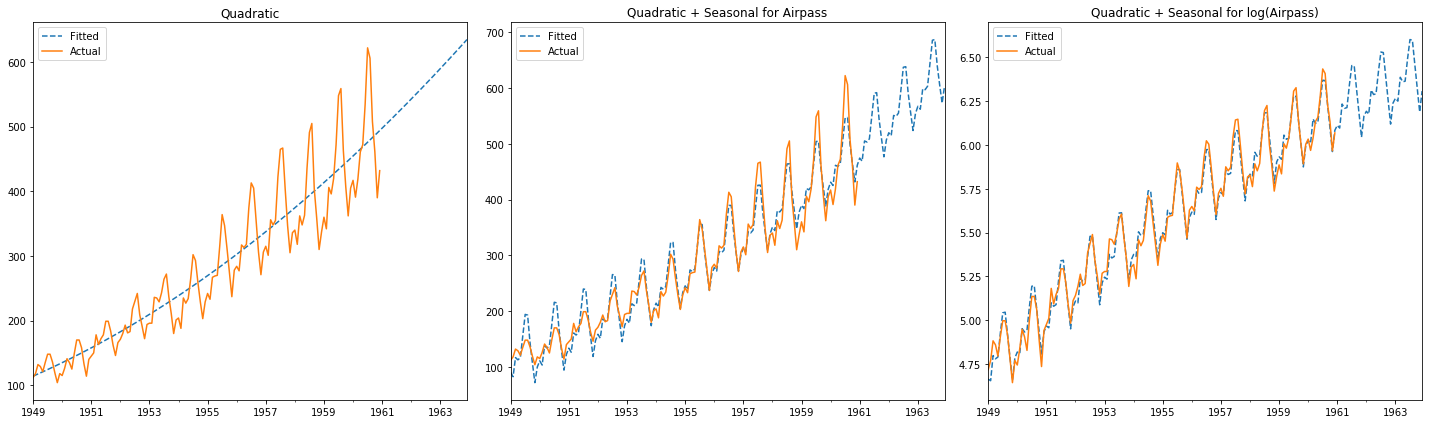

In [73]:
fig = plt.figure(figsize = (20, 6))
AP_fited_1.plot(ax = fig.add_subplot(131), linestyle = "--", title = "Quadratic")
airpass.plot(label = "Actual")
plt.legend()
#
AP_fited_2.plot(ax = fig.add_subplot(132), linestyle = "--", title = "Quadratic + Seasonal for Airpass")
airpass.plot(label = "Actual")
plt.legend()
#
AP_fited_3.plot(ax = fig.add_subplot(133), linestyle = "--", title = "Quadratic + Seasonal for log(Airpass)")
log_passengers.plot(label = "Actual")
plt.legend()
#
plt.tight_layout()
plt.show()

While the graph in the center attempts to capture the seasonality effect and it does so better than the left-side graph, we can see that the actual data fluctuations increase in size together with the level of airpass. So an additive model is unable to catch this effect. The common approach to this problem is to take the logarithms and estimate the additive model (right-side graph).

---

---

---

## (3.2) The Local Method of Exponential Smoothing

Exponential smoothing is a technique that can be applied to times series data, either to produce smoothed data for presentation or **to make forecasts**. 

While in the moving average decomposition the past observations are weighted equally, exponential functions are used to assign exponentially decreasing weights over time. It is an easily applied procedure for making some determination based on prior assumptions by the user, such as seasonality. Exponential smoothing is often used for analysis of time-series data.


### Simple Exponential Smoothing

We state the **simple exponential smoothing procedure** as an algorithm for converting the observed series $Y_t$ into a smoothed series $\widehat{Y}_t$, $t = 1,...,T$ and forecasts $\widehat{Y}_{T+h,T}$:

1. Initialize at $t = 1$: $\widehat{Y}_1 = Y_1$;
2. Update: $\widehat{Y}_t = \alpha Y_t + (1-\alpha) \widehat{Y}_{t-1}$, where $t=2,...,T$ and $\alpha \in (0,1)$;
3. Forecast: $\widehat{Y}_{T+h,T} = \widehat{Y}_T$, $h = 1,2,...$.

---
We will create a function which both smooths and forecasts a time series:

In [74]:
def exp_smooth_simple(pars, y_t, return_type = "simple", forc_period = 12):
    a = pars[0]
    T = len(y_t)
    #print(T)
    new_y = np.zeros(T)
    for i in range(0, T): #note - the first element (when i = 0 is unchanged
        if i == 0:
            new_y[i] = y_t[i]
        else:
            new_y[i] = a * y_t[i] + (1.0 - a) * new_y[i-1]  
    
    #Forecast ahead:
    y_forc = np.zeros(forc_period)
    for j in range(0, forc_period):
        y_forc[j] = new_y[T - 1]
        
    if return_type == "simple":
        return new_y
    else:
        return {"Y": new_y, "Forecast": y_forc}

The smaller $\alpha$ is, the smoother the estimated level. As $\alpha$ approaches 0, the smoothedseries approaches constantcy. As $\alpha$ approaches 1, the smoothes series pproaches point-by-point interpolation.

In [75]:
smoothed_data_1 = exp_smooth_simple([0.1], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast")
smoothed_data_2 = exp_smooth_simple([0.5], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast")
smoothed_data_3 = exp_smooth_simple([0.8], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast")

We will combine the fitted and forecast output

In [76]:
smoothed_data_1 = pd.Series(np.append(smoothed_data_1["Y"], smoothed_data_1["Forecast"]))
smoothed_data_2 = pd.Series(np.append(smoothed_data_2["Y"], smoothed_data_2["Forecast"]))
smoothed_data_3 = pd.Series(np.append(smoothed_data_3["Y"], smoothed_data_3["Forecast"]))

In [77]:
smoothed_data_1.name = "alpha = 0.1"
smoothed_data_2.name = "alpha = 0.5"
smoothed_data_3.name = "alpha = 0.8"

Change its time index to have a year and month instead of a generic index

In [78]:
smoothed_data_1.index = pd.date_range(start = "1949-01", periods = len(smoothed_data_1.index), freq = "M").to_period()
smoothed_data_1.index = smoothed_data_1.index.to_timestamp()
#
smoothed_data_2.index = smoothed_data_3.index = smoothed_data_1.index

Finally, we can plot the results as follows:

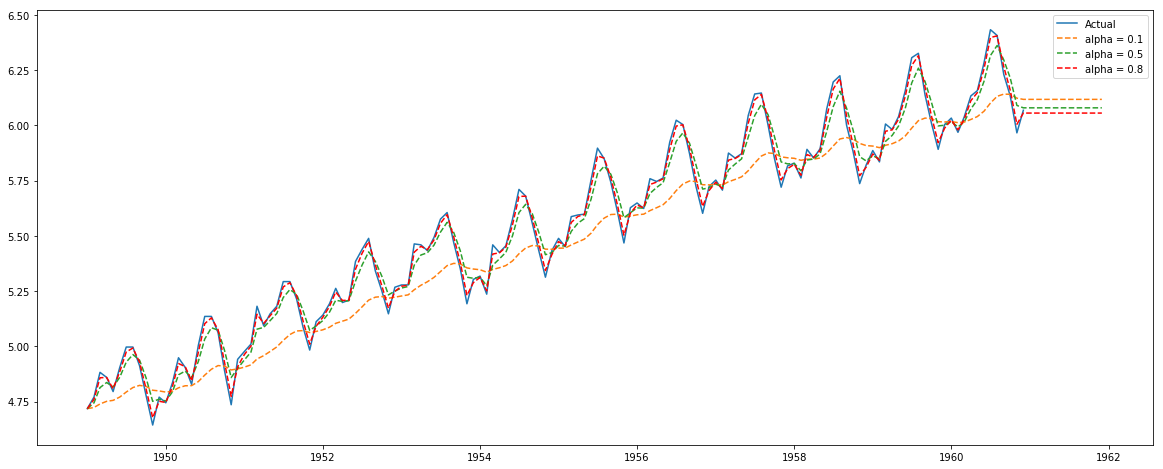

In [79]:
plt.figure(figsize = (20, 8))
plt.plot(log_passengers, label = "Actual")
plt.plot(smoothed_data_1, linestyle = "--")
plt.plot(smoothed_data_2, linestyle = "--")
plt.plot(smoothed_data_3, linestyle = "--", color = "red")
plt.legend()
plt.show()

---

Thankfully, the simple exponential smoothing is also implemented in `statsmodels` via [statsmodels.tsa.holtwinters.SimpleExpSmoothing(...)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing):

In [80]:
airpass_smpl_exp = smt.holtwinters.SimpleExpSmoothing(log_passengers)

We can select different smoothing levels:

In [81]:
airpass_smpl_exp_1 = airpass_smpl_exp.fit(smoothing_level = 0.1)
airpass_smpl_exp_2 = airpass_smpl_exp.fit(smoothing_level = 0.5)
airpass_smpl_exp_3 = airpass_smpl_exp.fit(smoothing_level = 0.8)

and plot the actual, fitted and forecast values as well:

In [82]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

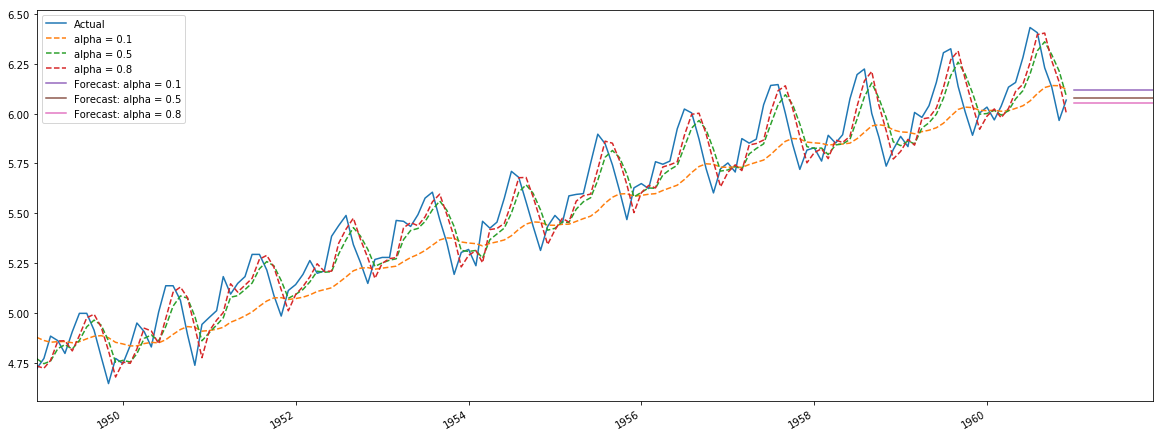

In [83]:
plt.figure(figsize = (20, 8))
plt.plot(log_passengers, label = "Actual")
airpass_smpl_exp_1.fittedvalues.plot(label = "alpha = 0.1", linestyle = "--")
airpass_smpl_exp_2.fittedvalues.plot(label = "alpha = 0.5", linestyle = "--")
airpass_smpl_exp_3.fittedvalues.plot(label = "alpha = 0.8", linestyle = "--")
airpass_smpl_exp_1.forecast(steps = 12).plot(label = "Forecast: alpha = 0.1")
airpass_smpl_exp_2.forecast(steps = 12).plot(label = "Forecast: alpha = 0.5")
airpass_smpl_exp_3.forecast(steps = 12).plot(label = "Forecast: alpha = 0.8")
plt.legend()
plt.show()

### **Note that the fitted values appear to be shifted to the left. A possible bug, perhaphs relating to the supressed FutureWarnings, will be updated shortly.**

### Double Exponential Smoothing

Now imagine that we have not only a slowly evolving local level, but also a trend with a slowly evolving local slope. In such cases simple exponential smoothing does not do well. Then the optimal smoothing algorithm (**Holt’s Linear Method**) is as follows:

1. Initialize at $t = 2$:

  1.1 $\widehat{Y_2} = Y_2$;
  
  1.2 $F_2 = Y_2 - Y_1$;
  
2. Update for $t > 2$:

  2.1 $\widehat{Y_t} = \alpha Y_t + (1- \alpha)\cdot (\widehat{Y}_{t-1} + F_{t-1})$, where $0 < \alpha < 1$;
  
  2.2 $F_t = \beta (\widehat{Y}_t - \widehat{Y}_{t-1}) + (1 - \beta) F_{t-1}$, where $0 < \beta < 1$;
  
3. Forecast: $\widehat{Y}_{T+h,T} = \widehat{Y}_T + h \cdot F_T$

Here $F_t$ is the best estimate of the trend and $\widehat{Y}_t$ is the smoothed series.

---

We can also estimate this manually:

In [84]:
def exp_smooth_double(pars, y_t, return_type = "simple", forc_period = 12):
    a = pars[0]
    b = pars[1]
    T = len(y_t)
    new_y = np.zeros(T)
    new_f = np.zeros(T)
    
    for i in range(0, T):
        if i == 0:
            new_y[i] = y_t[i]
            new_f[i] = y_t[i]
        elif i == 1:
            new_y[i] = y_t[i]
            new_f[i] = y_t[i] - y_t[i-1]
        else:
            new_y[i] = a * y_t[i] + (1.0 - a) * (new_y[i-1] + new_f[i-1])
            new_f[i] = b * (new_y[i] - new_y[i-1]) + (1.0 -  b) * new_f[i-1]

    #Forecast ahead:
    y_forc = np.zeros(forc_period)
    for j in range(0, forc_period):
        y_forc[j] = new_y[T - 1] + (j + 1) * new_f[T - 1]
    
    if return_type == "simple":
        return new_y
    else:
        return {"Y": new_y, "F": new_f, "Forecast": y_forc}

The parameter $\alpha$ controls smoothing of the level and $\beta$ controls smoothing of the slope.

We will present some examples with different $\alpha$ parameter values:

In [85]:
#Example of double exponential smoothing with different alpha parameters:
smoothed_data_1 = pd.Series(exp_smooth_double([0.1, 0.1], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast"))
smoothed_data_2 = pd.Series(exp_smooth_double([0.3, 0.1], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast"))
smoothed_data_3 = pd.Series(exp_smooth_double([0.6, 0.1], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast"))

In [86]:
smoothed_data_1 = pd.Series(np.append(smoothed_data_1["Y"], smoothed_data_1["Forecast"]))
smoothed_data_2 = pd.Series(np.append(smoothed_data_2["Y"], smoothed_data_2["Forecast"]))
smoothed_data_3 = pd.Series(np.append(smoothed_data_3["Y"], smoothed_data_3["Forecast"]))

In [87]:
smoothed_data_1.name = "alpha = 0.1, beta = 0.1"
smoothed_data_2.name = "alpha = 0.3, beta = 0.1"
smoothed_data_3.name = "alpha = 0.6, beta = 0.1"

In [88]:
smoothed_data_1.index = pd.date_range(start = "1949-01", periods = len(smoothed_data_1.index), freq = "M").to_period()
smoothed_data_1.index = smoothed_data_1.index.to_timestamp()
smoothed_data_2.index = smoothed_data_3.index = smoothed_data_1.index

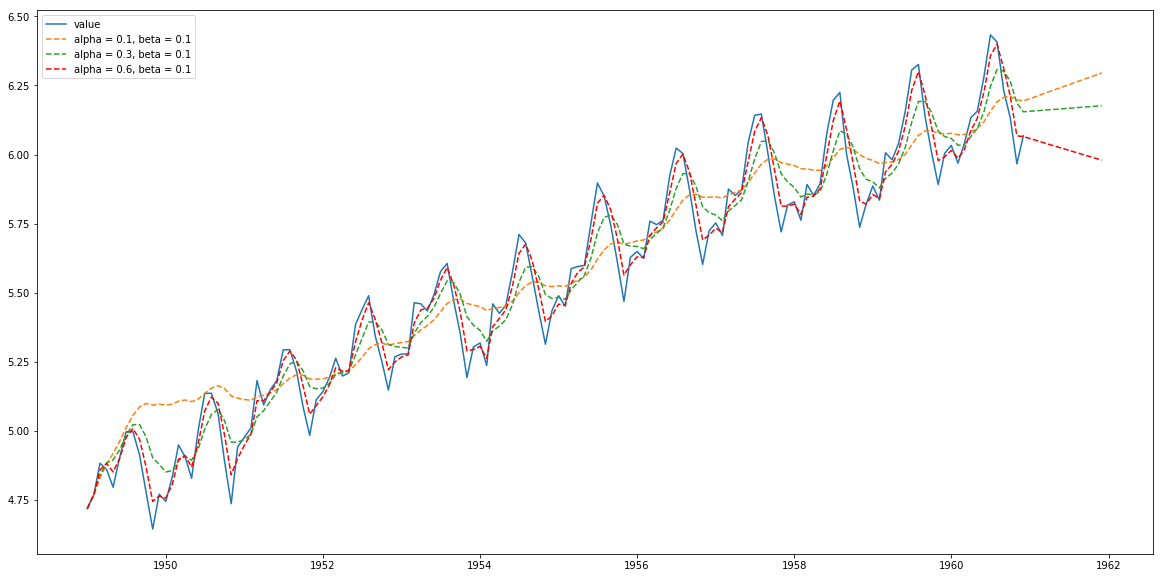

In [89]:
fig = plt.figure(figsize = (20, 10))
plt.plot(log_passengers)
plt.plot(smoothed_data_1, linestyle = "--")
plt.plot(smoothed_data_2, linestyle = "--")
plt.plot(smoothed_data_3, linestyle = "--", color = "red")
plt.legend()
plt.show()

We can also see how the smoothing changes depending on the $\beta$ value:

In [90]:
#Example of double exponential smoothing with different beta parameters:
smoothed_data_1 = pd.Series(exp_smooth_double([0.1, 0.01], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast"))
smoothed_data_2 = pd.Series(exp_smooth_double([0.1, 0.3], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast"))
smoothed_data_3 = pd.Series(exp_smooth_double([0.1, 0.9], np.array(pd.Series.tolist(log_passengers)), return_type = "forcast"))

In [91]:
smoothed_data_1 = pd.Series(np.append(smoothed_data_1["Y"], smoothed_data_1["Forecast"]))
smoothed_data_2 = pd.Series(np.append(smoothed_data_2["Y"], smoothed_data_2["Forecast"]))
smoothed_data_3 = pd.Series(np.append(smoothed_data_3["Y"], smoothed_data_3["Forecast"]))

In [92]:
smoothed_data_1.name = "alpha = 0.1, beta = 0.01"
smoothed_data_2.name = "alpha = 0.1, beta = 0.3"
smoothed_data_3.name = "alpha = 0.1, beta = 0.9"

In [93]:
smoothed_data_1.index = pd.date_range(start = "1949-01", periods = len(smoothed_data_1.index), freq = "M").to_period()
smoothed_data_1.index = smoothed_data_1.index.to_timestamp()
smoothed_data_2.index = smoothed_data_3.index = smoothed_data_1.index

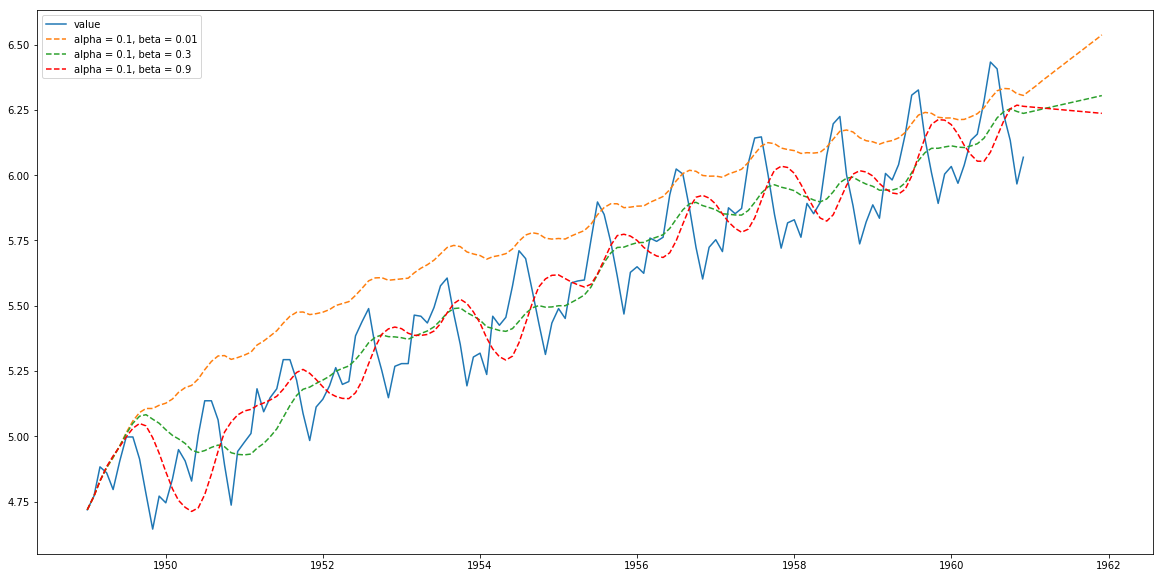

In [94]:
fig = plt.figure(figsize = (20, 10))
plt.plot(log_passengers)
plt.plot(smoothed_data_1, linestyle = "--")
plt.plot(smoothed_data_2, linestyle = "--")
plt.plot(smoothed_data_3, linestyle = "--", color = "red")
plt.legend()
plt.show()

---

The double exponential smoothing method is also implemented in [statsmodels.tsa.holtwinters.Holt(...)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt):

In [95]:
airpass_smpl_exp_x2 = smt.holtwinters.Holt(log_passengers)

In [96]:
airpass_smpl_exp_x2_11 = airpass_smpl_exp_x2.fit(smoothing_level = 0.1, smoothing_slope = 0.1)
airpass_smpl_exp_x2_12 = airpass_smpl_exp_x2.fit(smoothing_level = 0.3, smoothing_slope = 0.1)
airpass_smpl_exp_x2_13 = airpass_smpl_exp_x2.fit(smoothing_level = 0.6, smoothing_slope = 0.1)
airpass_smpl_exp_x2_21 = airpass_smpl_exp_x2.fit(smoothing_level = 0.1, smoothing_slope = 0.01)
airpass_smpl_exp_x2_22 = airpass_smpl_exp_x2.fit(smoothing_level = 0.1, smoothing_slope = 0.3)
airpass_smpl_exp_x2_23 = airpass_smpl_exp_x2.fit(smoothing_level = 0.1, smoothing_slope = 0.9)

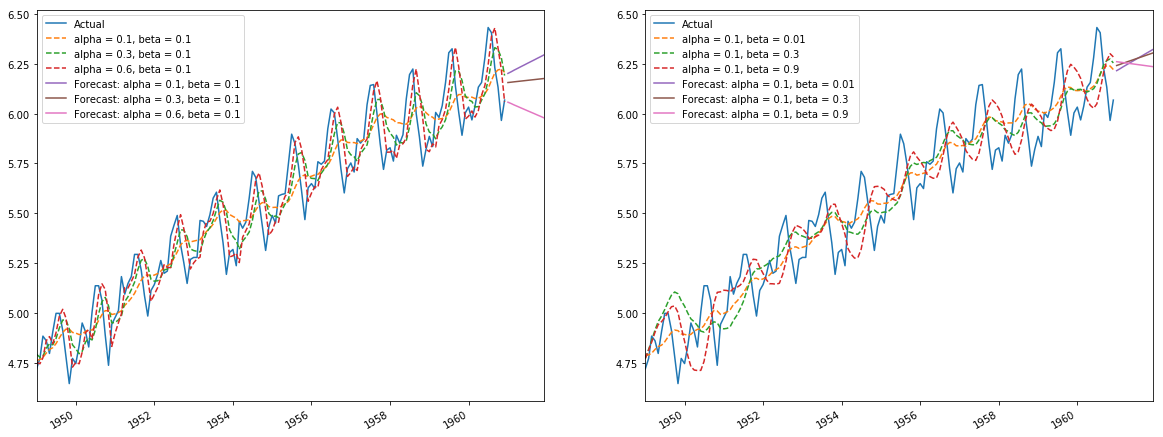

In [97]:
fig = plt.figure(figsize = (20, 8))
fig.add_subplot(121)
plt.plot(log_passengers, label = "Actual")
airpass_smpl_exp_x2_11.fittedvalues.plot(label = "alpha = 0.1, beta = 0.1", linestyle = "--")
airpass_smpl_exp_x2_12.fittedvalues.plot(label = "alpha = 0.3, beta = 0.1", linestyle = "--")
airpass_smpl_exp_x2_13.fittedvalues.plot(label = "alpha = 0.6, beta = 0.1", linestyle = "--")
airpass_smpl_exp_x2_11.forecast(steps = 12).plot(label = "Forecast: alpha = 0.1, beta = 0.1")
airpass_smpl_exp_x2_12.forecast(steps = 12).plot(label = "Forecast: alpha = 0.3, beta = 0.1")
airpass_smpl_exp_x2_13.forecast(steps = 12).plot(label = "Forecast: alpha = 0.6, beta = 0.1")
plt.legend()
#
fig.add_subplot(122)
plt.plot(log_passengers, label = "Actual")
airpass_smpl_exp_x2_21.fittedvalues.plot(label = "alpha = 0.1, beta = 0.01", linestyle = "--")
airpass_smpl_exp_x2_22.fittedvalues.plot(label = "alpha = 0.1, beta = 0.3", linestyle = "--")
airpass_smpl_exp_x2_23.fittedvalues.plot(label = "alpha = 0.1, beta = 0.9", linestyle = "--")
airpass_smpl_exp_x2_21.forecast(steps = 12).plot(label = "Forecast: alpha = 0.1, beta = 0.01")
airpass_smpl_exp_x2_22.forecast(steps = 12).plot(label = "Forecast: alpha = 0.1, beta = 0.3")
airpass_smpl_exp_x2_23.forecast(steps = 12).plot(label = "Forecast: alpha = 0.1, beta = 0.9")
plt.legend()
plt.show()

### **Note that the fitted values appear to be shifted to the left. A possible bug, perhaphs relating to the supressed FutureWarnings, will be updated shortly.**

### Triple Exponential Smoothing

A method known as **Holt-Winters method** is based on three smoothing equations - one for the level, one for the trend and one for seasonality. It is similar to Holt’s linear method, with one additional equation dealing with seasonality. 

Triple exponential smoothing applies exponential smoothing three times, which is commonly used when there are three high frequency signals to be removed from a time series under study. The use of a triple application is considered a rule of thumb technique, rather than one based on theoretical foundations and has often been over-emphasized by practitioners.

The smoothing algorithm (**where the seasonal effect is additive**) is as follows:

1. Initialize:

  1.1 Set $\widehat{Y}_L = \dfrac{Y_1 + ... + Y_L}{L}$
  
  1.2 The general formula for the initial trend: $F_L = \dfrac{1}{L} \left(\dfrac{Y_{L+1} - Y_1}{L} + \dfrac{Y_{L+2} - Y_2}{L} + ... \dfrac{Y_{L+L} - Y_L}{L} \right)$
  
  1.3 Suppose a cycle of seasonal change is of length L so that $G_t = G_{t+L}$ and $N$ - the number of somplete cycles in the data. As a rule of thumb, a minimum of two full seasons (or 2L periods) of historical data is needed to initialize a set of seasonal factors. The initial estimates for the seasonal indices: 
  $$
  \begin{aligned}
  G_i &= \dfrac{1}{N}\sum_{j = 1}^N{\dfrac{Y_{L(j-1)+i}}{A_j}}, \quad i = 1,...,L\\
  \text{where: } A_j &= \dfrac{1}{L} \sum_{k = 1}^L Y_{L(j-1)+k}, \quad j = 1,...,N
  \end{aligned}
  $$
  
  i.e. $A_j$ is the average value of $Y_t$ in the $j-th$ cycle of your data and $G_i$ is the average of the weighted values of the $i-th$ seasonal indice from all cycles.
  
  For example, if we have yearly data of $N$ years, then $A_1$ would be the average value of the first 12 month data $Y_1,...,Y_{12}$; and  $A_2$ - the average of $Y_{13},...,Y_{24}$, etc. 
  
  Then $G_1$ would be the average of the weighted values $\dfrac{Y_1}{A_1}, \dfrac{Y_{12 \cdot 2 + 1}}{A_2},..., \dfrac{Y_{12 \cdot N + 1}}{A_N}$, $G_2$ - the average of $\dfrac{Y_2}{A_1}, \dfrac{Y_{12 \cdot 2 + 2}}{A_2},..., \dfrac{Y_{12 \cdot N + 2}}{A_N}$ etc.
  
2. Two possible scenarios:
   
  - Update for $t > L$ of an **additive model**:

  2.1 $S_t = \alpha \left( Y_t - G_{t-L}\right) + (1- \alpha)\cdot (S_{t-1} + F_{t-1})$, where $0 < \alpha < 1$;
  
  2.2 $F_t = \beta (S_t - S_{t-1}) + (1 - \beta) F_{t-1}$, where $0 < \beta < 1$;
  
  2.3 $G_t = \gamma \left( Y_t-S_{t} \right) + (1 - \gamma) G_{t-L}$
   
  2.4 Forecast: $\widehat{Y}_{t+h} = \widehat{Y}_t + h \cdot F_t + G_{t + h - L}$ 
  
  - Update for $t > L$ of a **multiplicative model**:

  2.1 $S_t = \alpha \left( \dfrac{Y_t}{G_{t-L}}\right) + (1- \alpha)\cdot (S_{t-1} + F_{t-1})$, where $0 < \alpha < 1$;
  
  2.2 $F_t = \beta (S_t - S_{t-1}) + (1 - \beta) F_{t-1}$, where $0 < \beta < 1$;
  
  2.3 $G_t = \gamma \left( \dfrac{Y_t}{S_t} \right) + (1 - \gamma) G_{t-L}$
   
  2.4 Forecast: $\widehat{Y}_{t+h} = (\widehat{Y}_t + h \cdot F_t) \cdot G_{t + h - L}$

Here $F_t$ is the best estimate of the trend, $G_t$ is the best estimate of the seasonal factors and $S_t$ is the smoothed series.


It is also available in `statsmodels` as [statsmodels.tsa.holtwinters.ExponentialSmoothing(...)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing).

**We will not re-implement this method manually as it somewhat varies across different software.**

In [98]:
airpass_smpl_exp_hw = smt.holtwinters.ExponentialSmoothing(log_passengers)
airpass_smpl_exp_hw_1 = airpass_smpl_exp_hw.fit()

In [99]:
airpass_smpl_exp_hw2 = smt.holtwinters.ExponentialSmoothing(log_passengers, seasonal = "additive", seasonal_periods = 12)
airpass_smpl_exp_hw_2 = airpass_smpl_exp_hw2.fit()

In [100]:
airpass_smpl_exp_hw3 = smt.holtwinters.ExponentialSmoothing(log_passengers, seasonal = "multiplicative", seasonal_periods = 12)
airpass_smpl_exp_hw_3 = airpass_smpl_exp_hw3.fit()

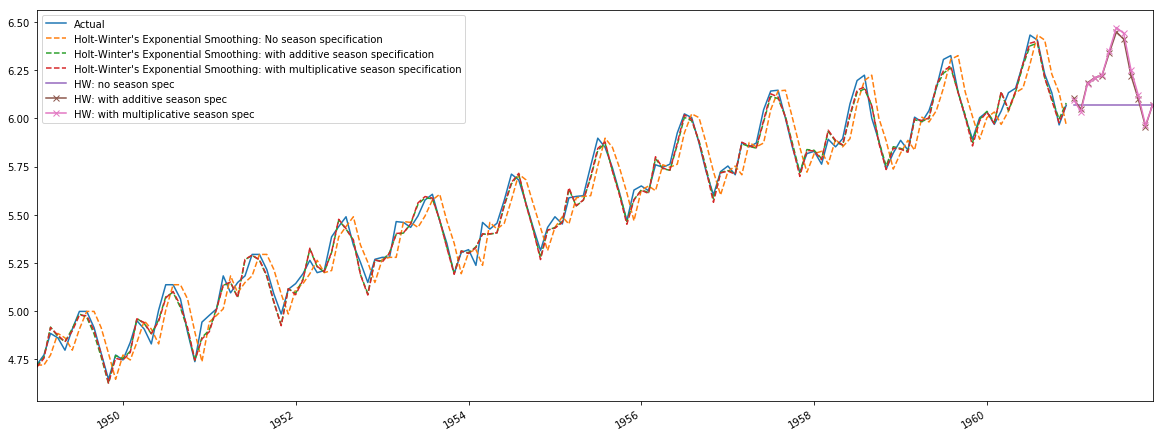

In [101]:
fig = plt.figure(figsize = (20, 8))
fig.add_subplot(111)
plt.plot(log_passengers, label = "Actual")
airpass_smpl_exp_hw_1.fittedvalues.plot(label = "Holt-Winter's Exponential Smoothing: No season specification", linestyle = "--")
airpass_smpl_exp_hw_2.fittedvalues.plot(label = "Holt-Winter's Exponential Smoothing: with additive season specification", linestyle = "--")
airpass_smpl_exp_hw_3.fittedvalues.plot(label = "Holt-Winter's Exponential Smoothing: with multiplicative season specification", linestyle = "--")
airpass_smpl_exp_hw_1.forecast(steps = 12).plot(label = "HW: no season spec")
airpass_smpl_exp_hw_2.forecast(steps = 12).plot(label = "HW: with additive season spec", marker = "x")
airpass_smpl_exp_hw_3.forecast(steps = 12).plot(label = "HW: with multiplicative season spec", marker = "x")
plt.legend()
plt.show()

### Generally the Holt-Winters exponential smoothing method is usually preferred to the simple and double exponential smoothing methods. (in `R` this can be carried out via the `ets()` function)

A similar [example](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm) with [data](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc436.htm).

---

### (3.3) Decomposition Method Comparison

The easiest way to compare the methods, besides looking at the plots, is to examine the residuals by looking at the residual series and ACF plots - are the residuals stationary? Are they WN?

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


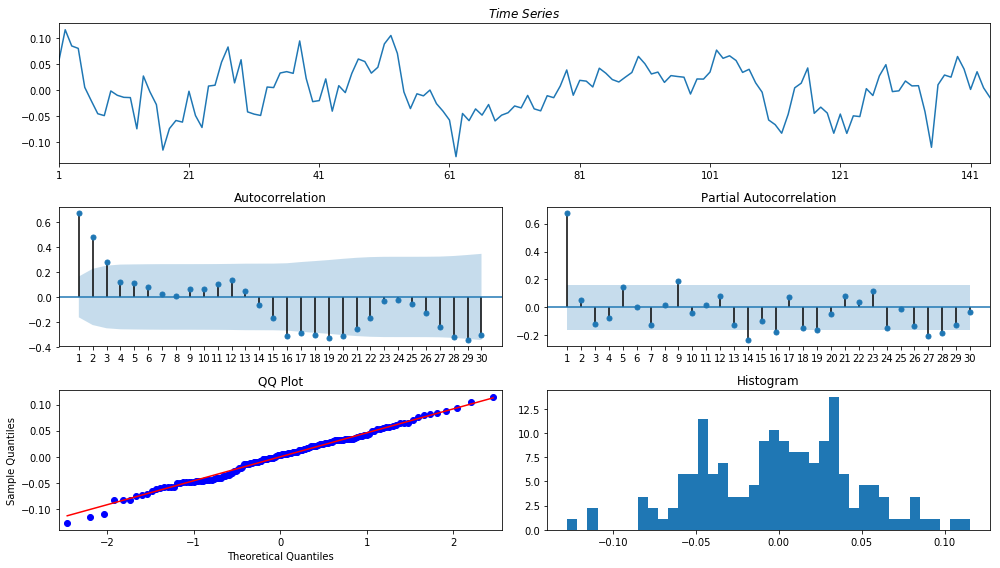

In [102]:
resid_OLS = fit_3.resid
tsdisplay(resid_OLS, lags = 30)

Note that only the first couple of lags are significant, while the latter ones are not as much.

We can also examine the residuals of the double exponential smoothing with $\alpha = 0.6$ and $\beta = 0.1$ as it appears to be the best fit:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


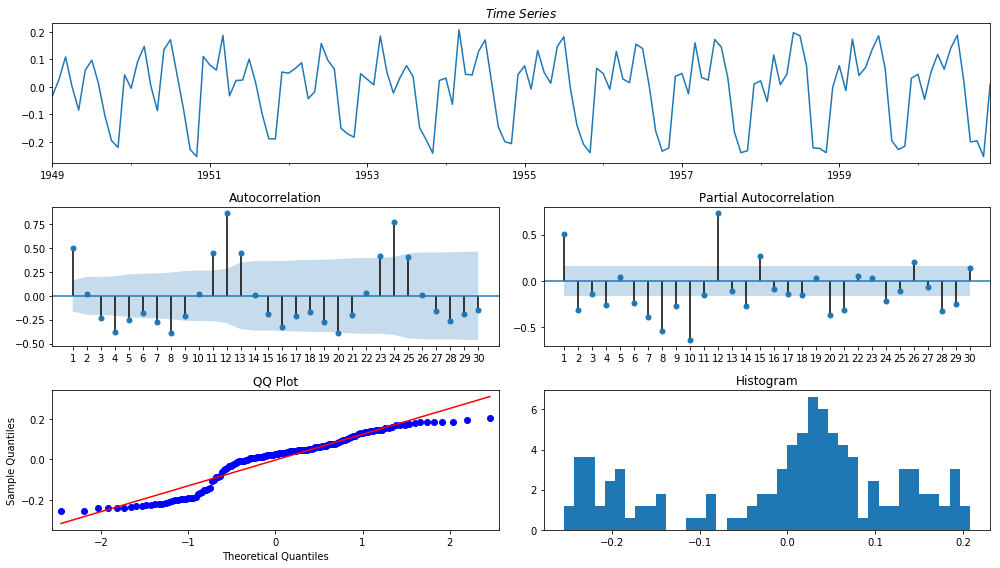

In [103]:
resid_exp_x2 = log_passengers - airpass_smpl_exp_x2_13.fittedvalues
tsdisplay(resid_exp_x2, lags = 30)

Note that in the case of using double exponential smoothing, there appears to be a seasonality or cyclic effect as every so often we see a lag spike. Overall, the double exponential smoothing method was ineffctive in capturing the seasonality effect.

Finally, the Hold-Winter's exponential smoothing method with a `multiplicative` seasonal component appear to have the best residuals (in terms of their white noise property):

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


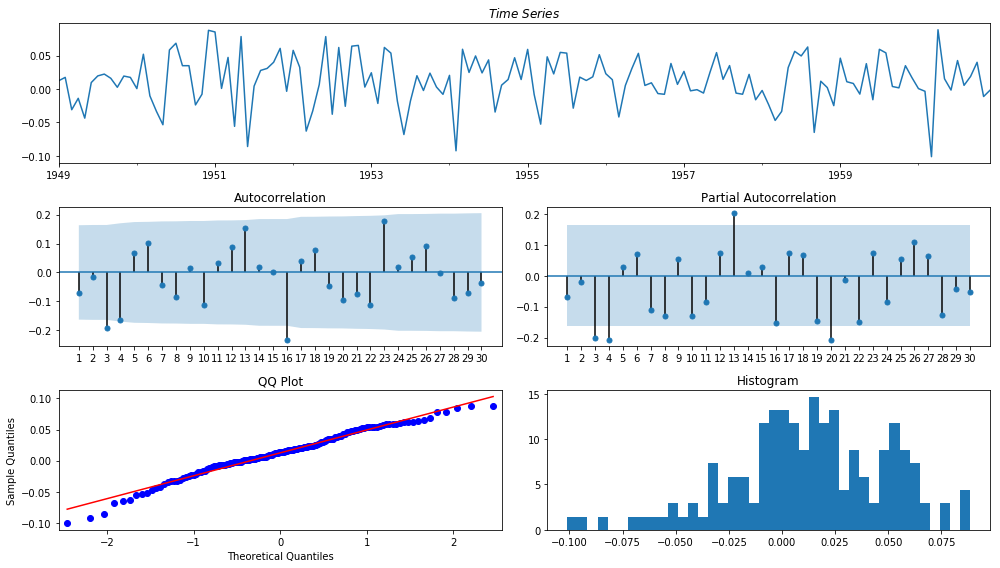

In [104]:
resid_hw = log_passengers - airpass_smpl_exp_hw_3.fittedvalues
tsdisplay(resid_hw, lags = 30)

Note that they may still be autocorrelated (again, the point of the decomposition is to separate the **deterministic** component from the **irregular, stationary** component, which is not necessarily white noise):

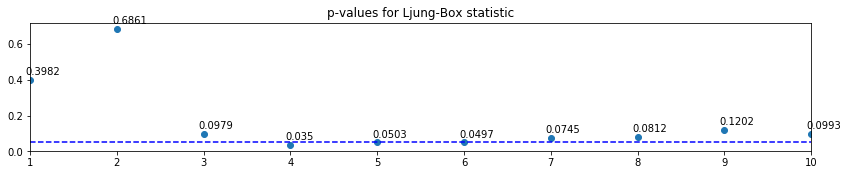

1         2         3          4          5   \
Ljung-Box: X-squared   0.713621  0.753500  6.299570  10.342808  11.056429   
Ljung-Box: p-value     0.398244  0.686088  0.097911   0.035033   0.050273   
Box-Pierce: X-squared  0.698957  0.737744  6.093880   9.970957  10.650364   
Box-Pierce: p-value    0.403134  0.691514  0.107131   0.040920   0.058770   

                              6          7          8          9          10  
Ljung-Box: X-squared   12.608610  12.903667  14.020535  14.059905  16.012826  
Ljung-Box: p-value      0.049690   0.074491   0.081232   0.120210   0.099266  
Box-Pierce: X-squared  12.117494  12.394363  13.434733  13.471136  15.263544  
Box-Pierce: p-value     0.059398   0.088313   0.097742   0.142421   0.122745

In [105]:
tsdiag(resid_hw)

but this can be solved by fitting an ARMA models on the residuals:

In [106]:
resid_mdl_order = sm.tsa.stattools.arma_order_select_ic(resid_hw, ic = 'aic', trend = 'nc')
resid_mdl_order

{'aic':             0           1           2
 0         NaN -523.176037 -522.755292
 1 -523.212204 -532.836147 -521.160686
 2 -522.302940 -520.594922 -530.042370
 3 -521.158977 -519.207492 -529.078153
 4 -519.461730 -518.213267 -527.349101, 'aic_min_order': (1, 1)}

In [107]:
resid_mdl_order.aic_min_order

(1, 1)

So, the residuals would need an $ARMA(1, 1)$ model. We will leave this as an additional exercise. Note that the final fitted values would need to be:

$
\text{Fitted values from Holt-Winter smoothing } + \text{ Fitted values from the residual ARMA model} 
$

Similarly the overall series forecast would be:

$
\text{Forecast from Holt-Winter smoothing } + \text{ Forecast from the residual ARMA model} 
$

---
---
---

## Additional Decomposition methods

Next we will examine a number of additional decomposition methods, which are no less important than the previously introduced methods.

### Seasonal ARMA

In order to fit the seasonal model, we first need to remove the trend component from the series (unless the series is a $DS$ series - something which will be examined in the next lecture).

We choose to use the residuals of the polynomial trend regression, but we will estimate the model on $\log(Y_t)$, since it appears that the series is multiplicative:

In [108]:
AP_OLS_trend = smf.ols(formula = 'np.log(AP) ~ time + time_sq', data = dtf)
AP_OLS_trend_fit = AP_OLS_trend.fit()
print(AP_OLS_trend_fit.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7364      0.034    138.117      0.000       4.669       4.804
time           0.0132      0.001     12.112      0.000       0.011       0.015
time_sq    -2.191e-05   7.29e-06     -3.004      0.003   -3.63e-05   -7.49e-06


c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


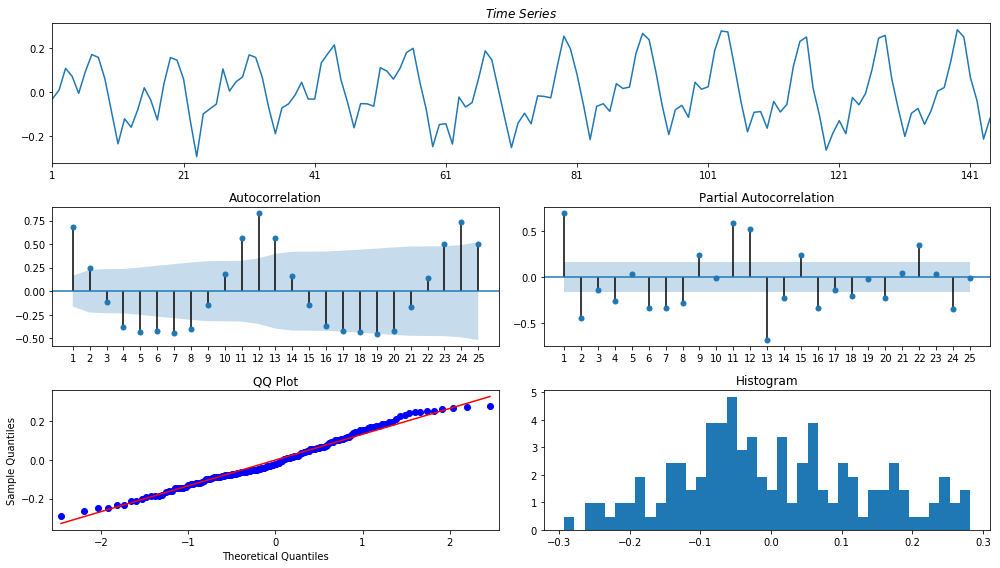

In [109]:
tsdisplay(AP_OLS_trend_fit.resid, lags = 25)

It appears the trend is estimated relatively well. The residuals appear to have a seasonal component but also a constant variance.

In order to model seasonality, we will estimate an $\rm SARIMA(p,d,q)(P,D,Q)_s$, restricting ourselvesto $d = D = 0$ (again, we will examine the model for differences in the following lectures).

Similarly to ARMA models, a lower lag order is usually sufficient. For example, if we wanted to estimate a $\rm SARIMA(2,0,2)(1,0,1)_{12}$ model (we select $s = 12$, since the data is monthly):

In [110]:
resid_sarima = sm.tsa.statespace.SARIMAX(AP_OLS_trend_fit.resid, order=(2, 0, 2), seasonal_order=(1, 0, 1, 12))
resid_sarima_fit = resid_sarima.fit()

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [111]:
print(resid_sarima_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 12)   Log Likelihood                 261.718
Date:                            Mon, 11 Mar 2019   AIC                           -509.436
Time:                                    16:41:12   BIC                           -488.647
Sample:                                         0   HQIC                          -500.988
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3250      2.149      0.617      0.538      -2.887       5.537
ar.L2         -0.4408      1.654   

 
 
-
    
 

Note that `sigma2` in the coefficients table is the estimate of the variance of the error term.

If we check the residuals of or model:

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


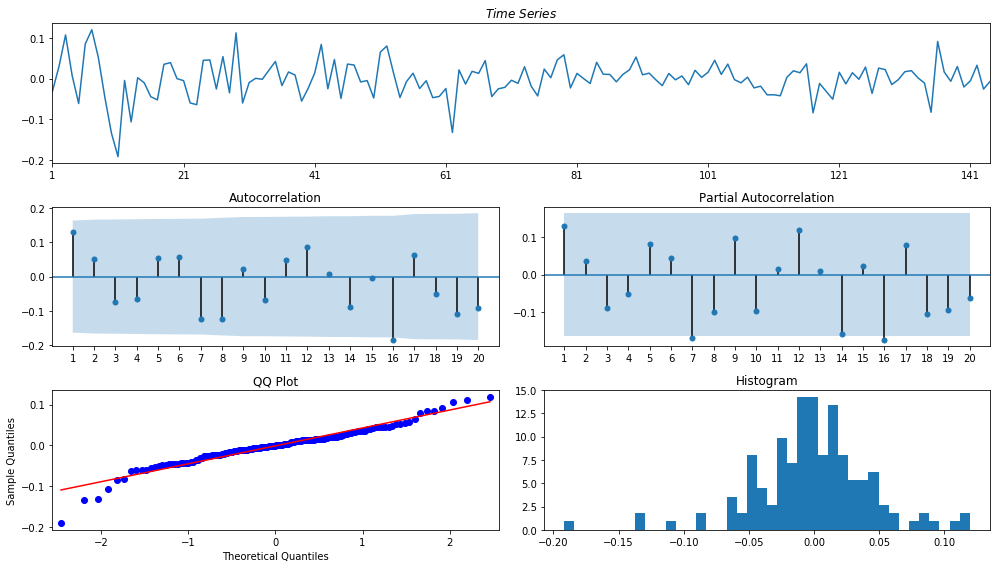

In [112]:
tsdisplay(resid_sarima_fit.resid)

we see that they appear to be uncorrelated. We do note that the variance of the residuals seems larger at the start of the series.

If we wanted to create our own simple automatic order selection, we can do so by editing our previous ARMA order selection code (from the GARCH example notebook):

In [113]:
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = sm.tools.sm_exceptions.ValueWarning)
warnings.filterwarnings("ignore", category = sm.tools.sm_exceptions.HessianInversionWarning)
warnings.filterwarnings("ignore", category = sm.tools.sm_exceptions.ConvergenceWarning)

In [114]:
# Specify the best AIC - default is infinite - so anything lower is better
best_aic = None
# Specify the best order
best_order = None
# Specify the best model
best_mdl = None
# Loop through different (p, q) combinations, starting from SARMA(0, 0)(0, 0), to SARMA(1, 1)(1, 1)
pq_rng = range(2) # range(5) would be [0,1,2,3,4]
for p in pq_rng:
    for q in pq_rng:
        for P in pq_rng:
            for Q in pq_rng:
                try:
                    tmp_mdl = sm.tsa.statespace.SARIMAX(AP_OLS_trend_fit.resid, 
                                                        order=(p, 0, q),
                                                        seasonal_order=(P, 0, Q, 12))
                    tmp_mdl_fit = tmp_mdl.fit()
                    tmp_aic = tmp_mdl_fit.aic
                    if best_aic == None:
                        best_aic = tmp_aic
                        best_order = {"Nonseasonal": (p, 0, q), "Seasonal": (P, 0, Q)}
                        best_mdl = tmp_mdl
                        print("Fitted an ARMA(" + str(p) + ", " + str(q) + ")(" + 
                              str(P) + ", " + str(Q) + ")_12 model - it was better")
                    elif tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = {"Nonseasonal": (p, 0, q), "Seasonal": (P, 0, Q)}
                        best_mdl = tmp_mdl
                        print("Fitted an ARMA(" + str(p) + ", " + str(q) + ")(" + 
                              str(P) + ", " + str(Q) + ")_12 model - it was better")
                    else:
                        print("Fitted an ARMA(" + str(p) + ", " + str(q) + ")(" + 
                              str(P) + ", " + str(Q) + ")_12 model - it was worse")
                except: continue

Fitted an ARMA(0, 0)(0, 0)_12 model - it was better
Fitted an ARMA(0, 0)(0, 1)_12 model - it was better
Fitted an ARMA(0, 0)(1, 0)_12 model - it was better
Fitted an ARMA(0, 0)(1, 1)_12 model - it was better
Fitted an ARMA(0, 1)(0, 0)_12 model - it was worse
Fitted an ARMA(0, 1)(0, 1)_12 model - it was worse
Fitted an ARMA(0, 1)(1, 0)_12 model - it was better
Fitted an ARMA(0, 1)(1, 1)_12 model - it was better
Fitted an ARMA(1, 0)(0, 0)_12 model - it was worse
Fitted an ARMA(1, 0)(0, 1)_12 model - it was worse
Fitted an ARMA(1, 0)(1, 0)_12 model - it was better
Fitted an ARMA(1, 0)(1, 1)_12 model - it was better
Fitted an ARMA(1, 1)(0, 0)_12 model - it was worse
Fitted an ARMA(1, 1)(0, 1)_12 model - it was worse
Fitted an ARMA(1, 1)(1, 0)_12 model - it was worse
Fitted an ARMA(1, 1)(1, 1)_12 model - it was better


For faster esimation, we have opted to fit a SARMA with a maximum lag order of `1` for all lags. The resulting model:

In [115]:
print(tmp_mdl_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 261.602
Date:                            Mon, 11 Mar 2019   AIC                           -513.203
Time:                                    16:41:17   BIC                           -498.354
Sample:                                         0   HQIC                          -507.169
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7873      0.091      8.614      0.000       0.608       0.966
ma.L1         -0.1896      0.127   

c:\users\andrius\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


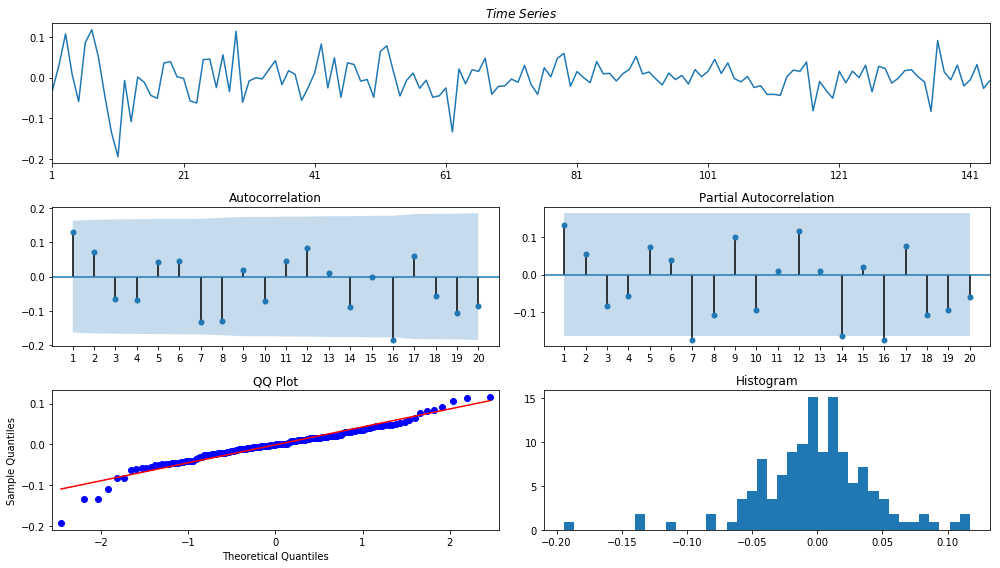

In [116]:
tsdisplay(tmp_mdl_fit.resid)

Seems similar in terms of residuals to our higher order seasonal ARMA specification. If we compare AIC/BIC values:

In [117]:
pd.DataFrame([[resid_sarima_fit.aic, tmp_mdl_fit.aic], 
              [resid_sarima_fit.bic, tmp_mdl_fit.bic]], 
             index = ["AIC", "BIC"], columns = ["Manual", "Auto"])

Manual        Auto
AIC -509.435632 -513.203134
BIC -488.646939 -498.354067

We see that the **automatic** specification has a **lower** AIC and BIC value, indicating that the $\rm SARIMA(1, 0, 1)(1, 0, 1)_{12}$ is the better model.

We can write the model using the lag functions as:

$(1 - 0.7873 L)\cdot (1 - 0.9900 L^{12})Y_t = (1 - 0.1896 L)\cdot (1 - 0.5948 L^{12})\epsilon_t$

---

### Combining Decomposition and Irregular component (i.e. residual) model forecasts

Firstly, we will calculate the fitted values.

In general, the fitted values can be calculated by:
    
 - Calculate the fitted values of the Trend component $\widehat{T}_t$;
 - Calculate the fitted values of the Seasonal component $\widehat{S}_t$;
 - Calculate the fitted values of the Irregular component $\widehat{E}_t$.

Then, we calculate the fitted values of the original series as $\widehat{Y}_t = \widehat{T}_t + \widehat{S}_t + \widehat{E}_t$.

In our case, we have estimated and **SARMA** model for $E_t$, which includes the seasonal component, and we have calculated the residuals from the OLS trend regression for the $\widehat{\log(Y)}_t$.

Hence $\widehat{Y}_t = \exp \left( \widehat{T}_t + \widehat{E}_{t}^{(SARMA)} \right)$

In [118]:
Y_fit = np.exp(AP_OLS_trend_fit.fittedvalues + resid_sarima_fit.fittedvalues)

In [119]:
Y_fit = pd.Series(Y_fit)
Y_fit.index = airpass.index

In [120]:
Y_trend = np.exp(AP_OLS_trend_fit.fittedvalues)
Y_trend = pd.Series(Y_trend)
Y_trend.index = airpass.index

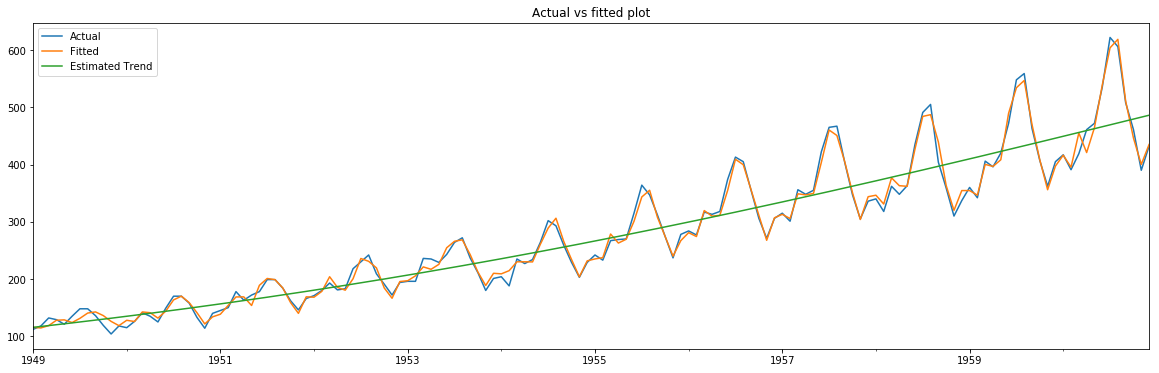

In [121]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(111)
#
airpass.plot(label = "Actual", ax = ax1)
Y_fit.plot(label = "Fitted", ax = ax1)
Y_trend.plot(label = "Estimated Trend", ax = ax1)
plt.title("Actual vs fitted plot")
plt.legend()
plt.show()

Next, we will calculate the forecasts for the trend component. We could do as before, and take an existing subset of `dtf` and modify its values, but for this example, we will create a variable matrix for forecasts from scratch.


We will begin by looking at the last values of `time` in the design matrix, which we used for fitting the OLS regrssion:

In [122]:
dtf.tail()

AP   time  time_sq  dm_1  dm_2  dm_3  dm_4  dm_5  dm_6  dm_7  dm_8  \
140  606.0  140.0  19600.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
141  508.0  141.0  19881.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
142  461.0  142.0  20164.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
143  390.0  143.0  20449.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
144  432.0  144.0  20736.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

     dm_9  dm_10  dm_11  
140   0.0    0.0    0.0  
141   1.0    0.0    0.0  
142   0.0    1.0    0.0  
143   0.0    0.0    1.0  
144   0.0    0.0    0.0

So, we will need the series to start from `145`. Since the OLS was fitted only for the trend, we will only need two column - `time` and `time_sq`:

In [123]:
time_forc = np.array(list(range(145, 145 + 20)))

In [124]:
dt_forc = pd.DataFrame([time_forc, time_forc**2], index = ["time", "time_sq"])

In [125]:
dt_forc.head()

0      1      2      3      4      5      6      7      8      9   \
time       145    146    147    148    149    150    151    152    153    154   
time_sq  21025  21316  21609  21904  22201  22500  22801  23104  23409  23716   

            10     11     12     13     14     15     16     17     18     19  
time       155    156    157    158    159    160    161    162    163    164  
time_sq  24025  24336  24649  24964  25281  25600  25921  26244  26569  26896

We need to transpose the dataset so that the column would correspond to different variables

In [126]:
dt_forc = dt_forc.T

In [127]:
dt_forc.head()

time  time_sq
0   145    21025
1   146    21316
2   147    21609
3   148    21904
4   149    22201

Now, we can calculate the forecast of the trend:

In [128]:
trend_forc = AP_OLS_trend_fit.predict(dt_forc)

In [129]:
trend_forc.head()

0    6.193382
1    6.200231
2    6.207037
3    6.213799
4    6.220517
dtype: float64

Note that this is the trend for the $\log(Y)_t$ series and not the oridinal series.

To calcualte the forecast of the $SARIMA$ model:

In [130]:
resid_forc = resid_sarima_fit.forecast(steps = len(dt_forc))

In [131]:
resid_forc.head()

144   -0.090128
145   -0.151566
146   -0.041038
147   -0.026169
148   -0.001763
dtype: float64

which is also for the $\log(Y)_t$ series.

Also the forecast of $SARMA$ and need to have the same index. Furthermore, since this is for **forecasts** (and not the *fitted* values, like before) - the index needs to start after the last index value of the historical data, so:

In [132]:
# the last date in the historical data
airpass.index[-1]

Timestamp('1960-12-01 00:00:00', freq='MS')

In [133]:
forc_index = pd.date_range(start = airpass.index[-1] + 1, periods = len(resid_forc.index), freq = "M").to_period()
forc_index = forc_index.to_timestamp()

In [134]:
forc_index

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
               '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [135]:
resid_forc.index = forc_index
trend_forc.index = forc_index

In order to calculate for $Y_t$, we do as before and either calculate $\exp ( \widehat{T}_t + \widehat{E}_t )$, or equivalently $\exp ( \widehat{T}_t ) \cdot exp (\widehat{E}_t )$.

In [136]:
np.exp(resid_forc + trend_forc).head()

1961-01-01    447.310710
1961-02-01    423.547314
1961-03-01    476.276916
1961-04-01    486.691421
1961-05-01    502.077415
Freq: MS, dtype: float64

In [137]:
(np.exp(resid_forc) * np.exp(trend_forc)).head()

1961-01-01    447.310710
1961-02-01    423.547314
1961-03-01    476.276916
1961-04-01    486.691421
1961-05-01    502.077415
Freq: MS, dtype: float64

We will use the first method:

In [138]:
Y_forc = np.exp(resid_forc + trend_forc)

In [139]:
pd.Series(Y_forc)

1961-01-01    447.310710
1961-02-01    423.547314
1961-03-01    476.276916
1961-04-01    486.691421
1961-05-01    502.077415
1961-06-01    573.615339
1961-07-01    654.864397
1961-08-01    651.981305
1961-09-01    548.467127
1961-10-01    488.792375
1961-11-01    424.253313
1961-12-01    469.623409
1962-01-01    485.480187
1962-02-01    459.742859
1962-03-01    516.039121
1962-04-01    526.831537
1962-05-01    542.926908
1962-06-01    619.030803
1962-07-01    705.316283
1962-08-01    701.813037
Freq: MS, dtype: float64

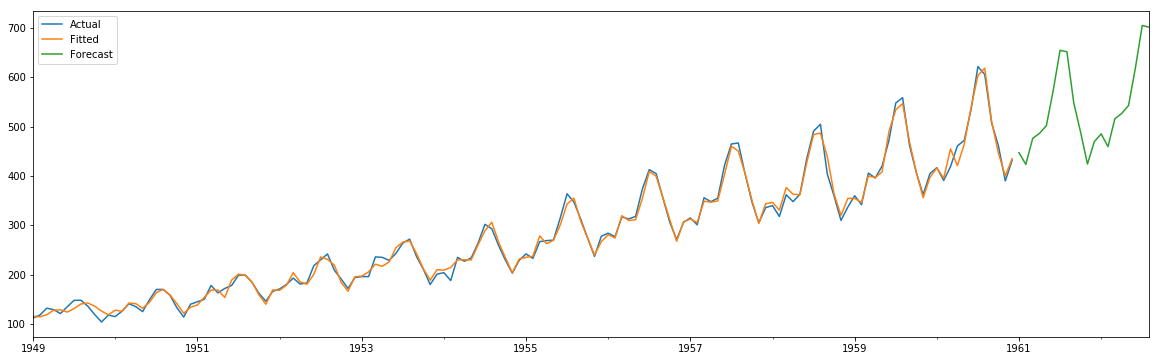

In [140]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(111)
#
airpass.plot(label = "Actual", ax = ax1)
Y_fit.plot(label = "Fitted", ax = ax1)
Y_forc.plot(label = "Forecast", ax = ax1)
#
plt.legend()
plt.show()

----

# Additional Smoothing Methods

Here we will present some of the additional smoothing methods mentioned during the lectures,

## Kernel Smoothing

We need to pass the data as a `float` type, otherwise we would get a `Buffer dtype mismatch, expected 'DOUBLE' but got 'long long'` error.

We will use the [KDEUnivariate](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.kde.KDEUnivariate.fit.html#statsmodels.nonparametric.kde.KDEUnivariate.fit) function, which calculates the conditional mean $\mathbb{E}(Y|X)$ where $Y = g(X) + \epsilon$. 

Note that the “local constant” type of regression provided here known as **Nadaraya-Watson kernel regression** - which is exactly what we need for the kernel smoothing method:

In [141]:
airpass_ks = sm.nonparametric.KernelReg(endog = airpass, exog = time, var_type = "c", reg_type = "lc")

In [142]:
airpass_ks_fit = airpass_ks.fit()

In [143]:
airpass_ks_smoothed = pd.Series(airpass_ks_fit[0])
airpass_ks_smoothed.index = airpass.index

We can also compare it with the moving-average smoothing method (i.e. the MA decomposition):

In [144]:
airpass_ma  = smt.seasonal.seasonal_decompose(airpass, model = "muliplicative", freq = 12, two_sided = False)
airpass_ma_smoothed = airpass_ma.trend

The plot of the two smoothing methods side-by-side:

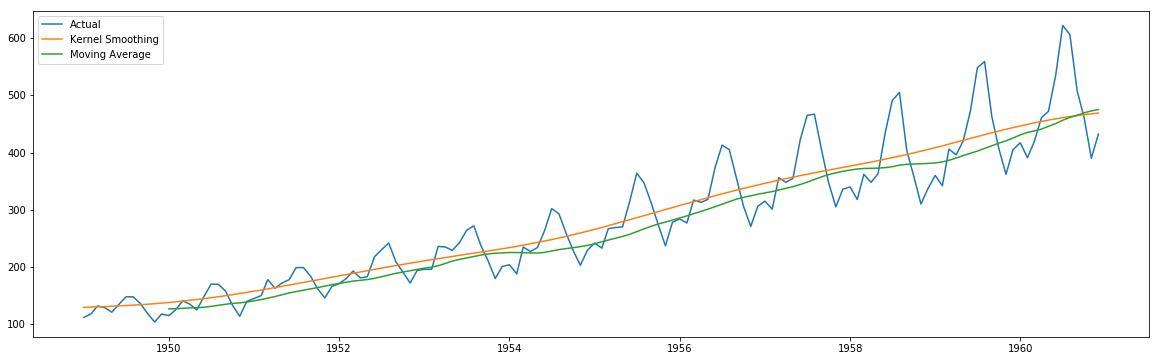

In [145]:
plt.figure(figsize = (20, 6))
#
plt.plot(airpass, label = "Actual")
plt.plot(airpass_ks_smoothed, label = "Kernel Smoothing")
plt.plot(airpass_ma_smoothed, label = "Moving Average")
#
plt.legend()
plt.show()

---

## LOWESS (Locally Weighted Scatterplot Smoothing)

The LO(W)ESS method can also be used in `Python`:

In [146]:
airpass_lowess = sm.nonparametric.lowess(endog = airpass, exog = time)

In [147]:
airpass_lowess_smoothed = pd.Series(airpass_lowess[:, 1])
airpass_lowess_smoothed.index = airpass.index

By default, $66.67\%$ the data is used for each value.

We can also adjust the `fraction` of the data used when estimating each value. E.g.$5\%$:

In [148]:
airpass_lowess_5pct = sm.nonparametric.lowess(endog = airpass, exog = time, frac = 0.05)

In [149]:
airpass_lowess_5pct_smoothed = pd.Series(airpass_lowess_5pct[:, 1])
airpass_lowess_5pct_smoothed.index = airpass.index

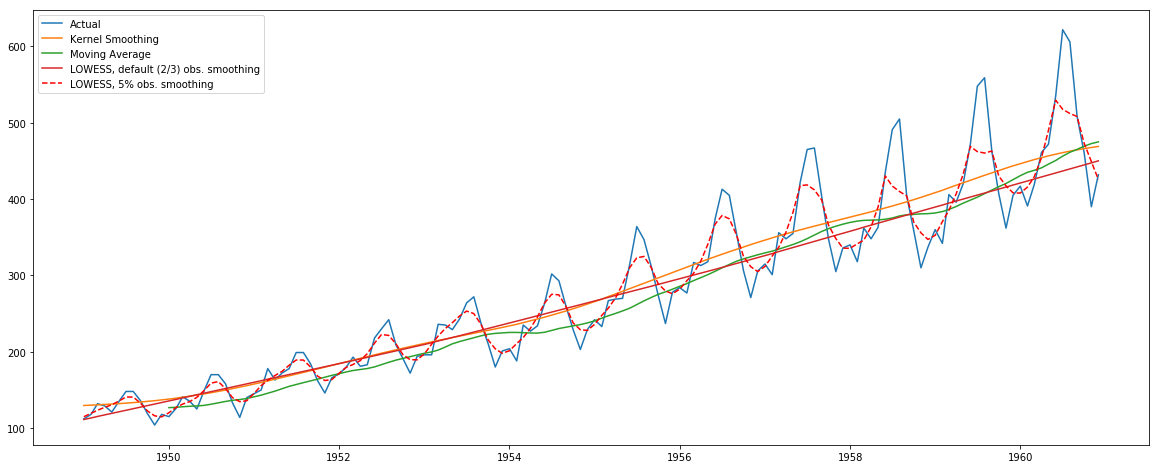

In [150]:
plt.figure(figsize = (20, 8))
#
plt.plot(airpass, label = "Actual")
plt.plot(airpass_ks_smoothed, label = "Kernel Smoothing")
plt.plot(airpass_ma_smoothed, label = "Moving Average")
plt.plot(airpass_lowess_smoothed, label = "LOWESS, default (2/3) obs. smoothing")
plt.plot(airpass_lowess_5pct_smoothed, label = "LOWESS, 5% obs. smoothing", color = "red", linestyle = "--")
#
plt.legend()
plt.show()

---

## Cubic Smoothing Splines

Some examples of cubic splines in `Python` can be found:

- [Link 1](http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab13/Lab%2013%20-%20Splines%20in%20Python.pdf)
- [Link 2](https://patsy.readthedocs.io/en/latest/spline-regression.html)

In order to fit regression splines in python, we use the `dmatrix` module from the `patsy` library. Regression splines can be fit by constructing an appropriate matrix of basis functions.

In [151]:
from patsy import dmatrix

In [152]:
transformed_x2 = dmatrix("cr(time, df = 3)", {"time": time}, return_type = 'dataframe')
transformed_x2.index = airpass.index

where `cr()` is used for a natural cubic regression spline basis.

In [153]:
airpass_cubic_spline = sm.GLM(airpass, transformed_x2)
airpass_cubic_smoothed = airpass_cubic_spline.fit()

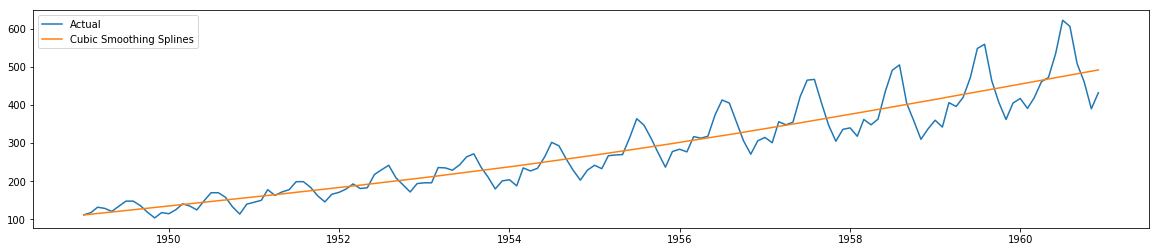

In [154]:
plt.figure(figsize = (20, 4))
#
plt.plot(airpass, label = "Actual")
plt.plot(airpass_cubic_smoothed.fittedvalues, label = "Cubic Smoothing Splines")
#
plt.legend()
plt.show()

Finally, we can compare all of these smoothing methods:

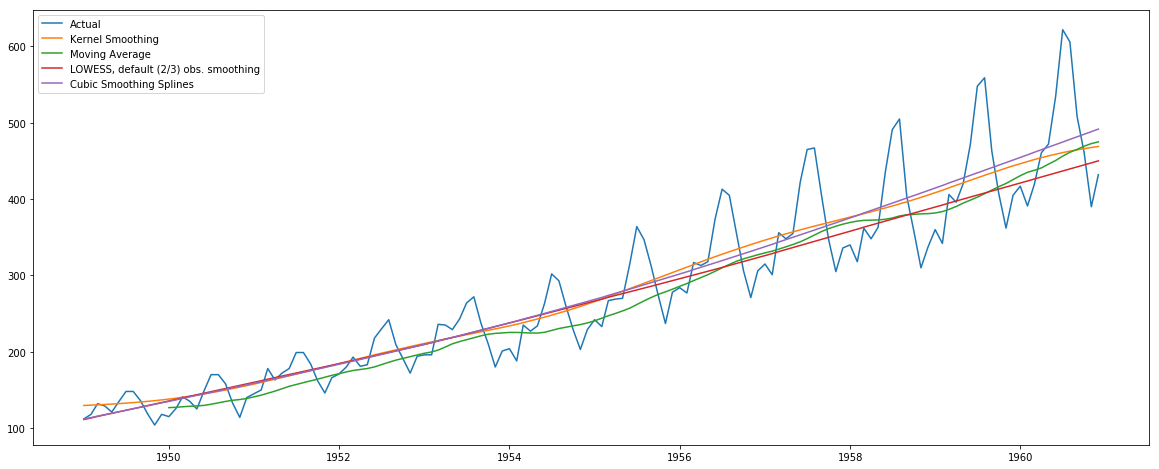

In [155]:
plt.figure(figsize = (20, 8))
#
plt.plot(airpass, label = "Actual")
plt.plot(airpass_ks_smoothed, label = "Kernel Smoothing")
plt.plot(airpass_ma_smoothed, label = "Moving Average")
plt.plot(airpass_lowess_smoothed, label = "LOWESS, default (2/3) obs. smoothing")
plt.plot(airpass_cubic_smoothed.fittedvalues, label = "Cubic Smoothing Splines")
#
plt.legend()
plt.show()